In [1]:
import pandas as pd
import os
import gc
import json
from pathlib import Path
import seaborn as sns
from copy import copy
sns.mpl.rcParams['axes.formatter.useoffset'] = False
sns.set_style('whitegrid')
import numpy as np
from collections import defaultdict
from scipy.interpolate import interp1d, interp2d, splrep, splev
from scipy.optimize import minimize, brentq
from itertools import product
%matplotlib inline

root = '../calc/2017-01-23-all-vdw-sets-3'
import sys
sys.path.append(root)
import caf
from caflib.Cellar import Cellar
from caflib.Utils import slugify
import vdwsets.vdwsets as vdw
from cscript import b_vv10_values

ev = 27.2107
kcal = 627.503

def get_some(d, *keys):
    for key in keys:
        if key in d:
            return d[key]
        
def normalize_names(col):
    if col.name == 'xc':
        return col.str.upper()
    return col

def savefig(name, **kwargs):
    sns.plt.savefig(os.path.expanduser(f'../media/{name}.pdf'), transparent=True, **kwargs)

In [2]:
cellar = Cellar(f'{root}/.caf')
tree = cellar.get_tree(objects=True)
methods = [p.split('/')[-1] for p in tree.dglob('S22/*/*/<>')]
methods

['b3lyp',
 'b3lyp-light',
 'dftd3',
 'lda',
 'm06',
 'm06-light',
 'mbd',
 'pbe',
 'pbe-light',
 'pbe0',
 'pbe0-light',
 'scan',
 'scan(a)',
 'scan(b)',
 'scan-light',
 'scan0',
 'scan0-light',
 'vv10']

In [3]:
%%time
data_scf = []
data_mbd = []
data_dftd3_0 = []
data_dftd3_bj = []
data_vv10 = []
data_vv10_raw = []
for name, ds in vdw.get_all_datasets().items():
    for key, cluster in ds.clusters.items():
        keypath = slugify('_'.join(map(str, key)))
        system, dist = key if len(key) == 2 else (key[0], 1.)
        refs = cluster.energies
        ref = refs['ref'] if 'ref' in refs else refs['ref-grimme']
        for method in 'b3lyp lda m06 pbe pbe0 scan scan0 mbd dftd3 scan(a) scan(b)'.split():
            enes = {}
            for fragment in cluster.fragments:
                path = f'{name}/{keypath}/{fragment}/{method}'
                hashid = tree[path]
                if 'outputs' not in tree.objects[hashid]:
                    continue
                results_file = 'mbd.json' if method == 'mbd' else 'results.json'
                filehash = tree.objects[hashid]['outputs'][results_file]
                with open(cellar.get_file(filehash)) as f:
                    results = json.load(f)
                enes[fragment] = list(sorted(results)) if method in ['mbd', 'dftd3'] else results['scf_energy']
            if len(enes) != len(cluster.fragments):
                continue
            if method == 'mbd':
                for i, (beta, a, _) in enumerate(list(enes.values())[0]):
                    data_mbd.append((
                        name, system, dist, a, beta, cluster.get_int_ene(
                            {f: enes[f][i][2] for f in cluster.fragments}
                        )*kcal,
                    ))
                data_mbd.append((name, system, dist, 6., 10., 0.))
            elif method == 'dftd3':
                for i, (damping, *params, _, _) in enumerate(list(enes.values())[0]):
                    (data_dftd3_0 if damping == 'zero' else data_dftd3_bj).append((
                        name, system, dist, *params,
                        cluster.get_int_ene(
                            {f: enes[f][i][-2] for f in cluster.fragments}
                        )*kcal,
                        cluster.get_int_ene(
                            {f: enes[f][i][-1] for f in cluster.fragments}
                        )*kcal
                    ))
                data_dftd3_bj.append((name, system, dist, 1., 50., 1., 0., 0.))
                data_dftd3_0.append((name, system, dist, 10., 10., 1., 0., 0.))
            else:
                data_scf.append((
                    name, system, dist, method,
                    cluster.get_int_ene(enes)/ev*kcal, ref,
                    len(ds.geoms[get_some(cluster.fragments, 'complex', 'dimer', 'crystal', 'ABC')])
                ))
        if name not in ['S22', 'X23', 'S66x8', 'S12L']:
            continue
        enes = defaultdict(dict)
        for fragment in cluster.fragments:
            for xc, b_vv10 in product(['base', 'vdw', 'vdw2'], b_vv10_values):
                path = f'{name}/{keypath}/{fragment}/vv10/{b_vv10}/{xc}'
                hashid = tree[path]
                if 'outputs' not in tree.objects[hashid]:
                    continue
                filehash = tree.objects[hashid]['outputs']['results.json']
                with open(cellar.get_file(filehash)) as f:
                    results = json.load(f)
                enes[b_vv10, xc][fragment] = results['energy']
                data_vv10_raw.append((
                    name, system, dist, b_vv10, xc, fragment, results['energy']*kcal/2
                ))
                if xc == 'vdw2':
                    enes[b_vv10, 'nlc'][fragment] = results['nlc']
                    data_vv10_raw.append((
                        name, system, dist, b_vv10, 'nlc', fragment, results['nlc']*kcal/2
                    ))
        for (b_vv10, xc), enes in enes.items():
            if len(enes) != len(cluster.fragments):
                continue
            data_vv10.append((
                name, system, dist, b_vv10, xc, cluster.get_int_ene(enes)*kcal/2
            ))
data_scf = pd.DataFrame.from_records(
    data_scf,
    columns='name system dist xc ene ref natoms'.split()
).set_index('name system dist xc'.split(), verify_integrity=True).sort_index()
data_mbd = pd.DataFrame.from_records(
    data_mbd,
    columns='name system dist a beta ene'.split()
).set_index('name system dist a beta'.split(), verify_integrity=True).sort_index()
data_dftd3_0 = pd.DataFrame.from_records(
    data_dftd3_0,
    columns='name system dist sr6 sr8 s8 ene ene3'.split()
).set_index('name system dist sr6 sr8 s8'.split(), verify_integrity=True).sort_index()
data_dftd3_bj = pd.DataFrame.from_records(
    data_dftd3_bj,
    columns='name system dist a1 a2 s8 ene ene3'.split()
).set_index('name system dist a1 a2 s8'.split(), verify_integrity=True).sort_index()
data_vv10 = pd.DataFrame.from_records(
    data_vv10,
    columns='name system dist b xc ene'.split()
).set_index('name system dist b xc'.split(), verify_integrity=True).sort_index()
# ['ene'] \ .unstack().apply(lambda r: r['vdw']-r['base'], axis=1).to_frame('ene')
data_vv10_raw = pd.DataFrame.from_records(
    data_vv10_raw,
    columns='name system dist b xc fragment ene'.split()
).set_index('name system dist b xc fragment'.split(), verify_integrity=True).sort_index()['ene']
gc.collect()

CPU times: user 3min 27s, sys: 22 s, total: 3min 49s
Wall time: 4min 8s


In [4]:
len(data_scf), len(data_mbd), len(data_dftd3_bj), len(data_dftd3_0), len(data_vv10), len(data_vv10_raw)

(10127, 183222, 7153575, 815451, 9456, 28000)

In [5]:
# filter out data points where dist = 2 and reference energy is nonnegative
mask = (data_scf.index.get_level_values('dist') == 2.) & (data_scf['ref'] >= 0)
data_scf.drop(data_scf.loc[mask].index, inplace=True)

In [6]:
# set base to abs(ref) and flatten the dip around ref = 0
def mod_ref1(df):
    if len(df) == 1:
        return df
    ibase = df['ref'].idxmin()
    base = df.loc[ibase, 'base']
    dist = ibase[2]
    mask = (df.index.get_level_values('dist') < dist) & (df['base'] < base)
    df.loc[mask, 'base'] = base
    return df

data_scf = data_scf \
    .assign(base=lambda x: abs(x['ref'])) \
    .groupby(level='name system xc'.split()) \
    .apply(mod_ref1)

In [7]:
def get_stat(df):
    return pd.Series({
        'STD': df['reldelta'].std(),
        'mean': df['reldelta'].mean(),
        'MARE': abs(df['reldelta']).mean(),
        'MAE': abs(df['delta']).mean()
    })
    
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    mare = interp1d(df['beta'], df['MARE'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    sns.plt.plot(beta, mean(beta), '--', **kwargs)
    sns.plt.plot(beta, std(beta), '-', **kwargs)
    sns.plt.plot(beta, mare(beta), ':', **kwargs)
    sns.plt.axhline(color='black')

def zero_dist(df):
    df = df.copy()
    df['dist'] = 1.
    df['name'] = df['name'] + '_T'
    return df

## MBD

In [8]:
data = pd.merge(
    data_scf.reset_index(),
    data_mbd.reset_index(),
    on='name system dist'.split(),
    how='inner',
    suffixes=('_scf', '_mbd')
).set_index('name xc system dist a beta'.split()).sort_index()

In [9]:
data = data \
    .assign(ene=lambda x: x['ene_scf']+x['ene_mbd']) \
    .assign(delta=lambda x: x['ene']-x['ref']) \
    .assign(reldelta=lambda x: x['delta']/x['base'])

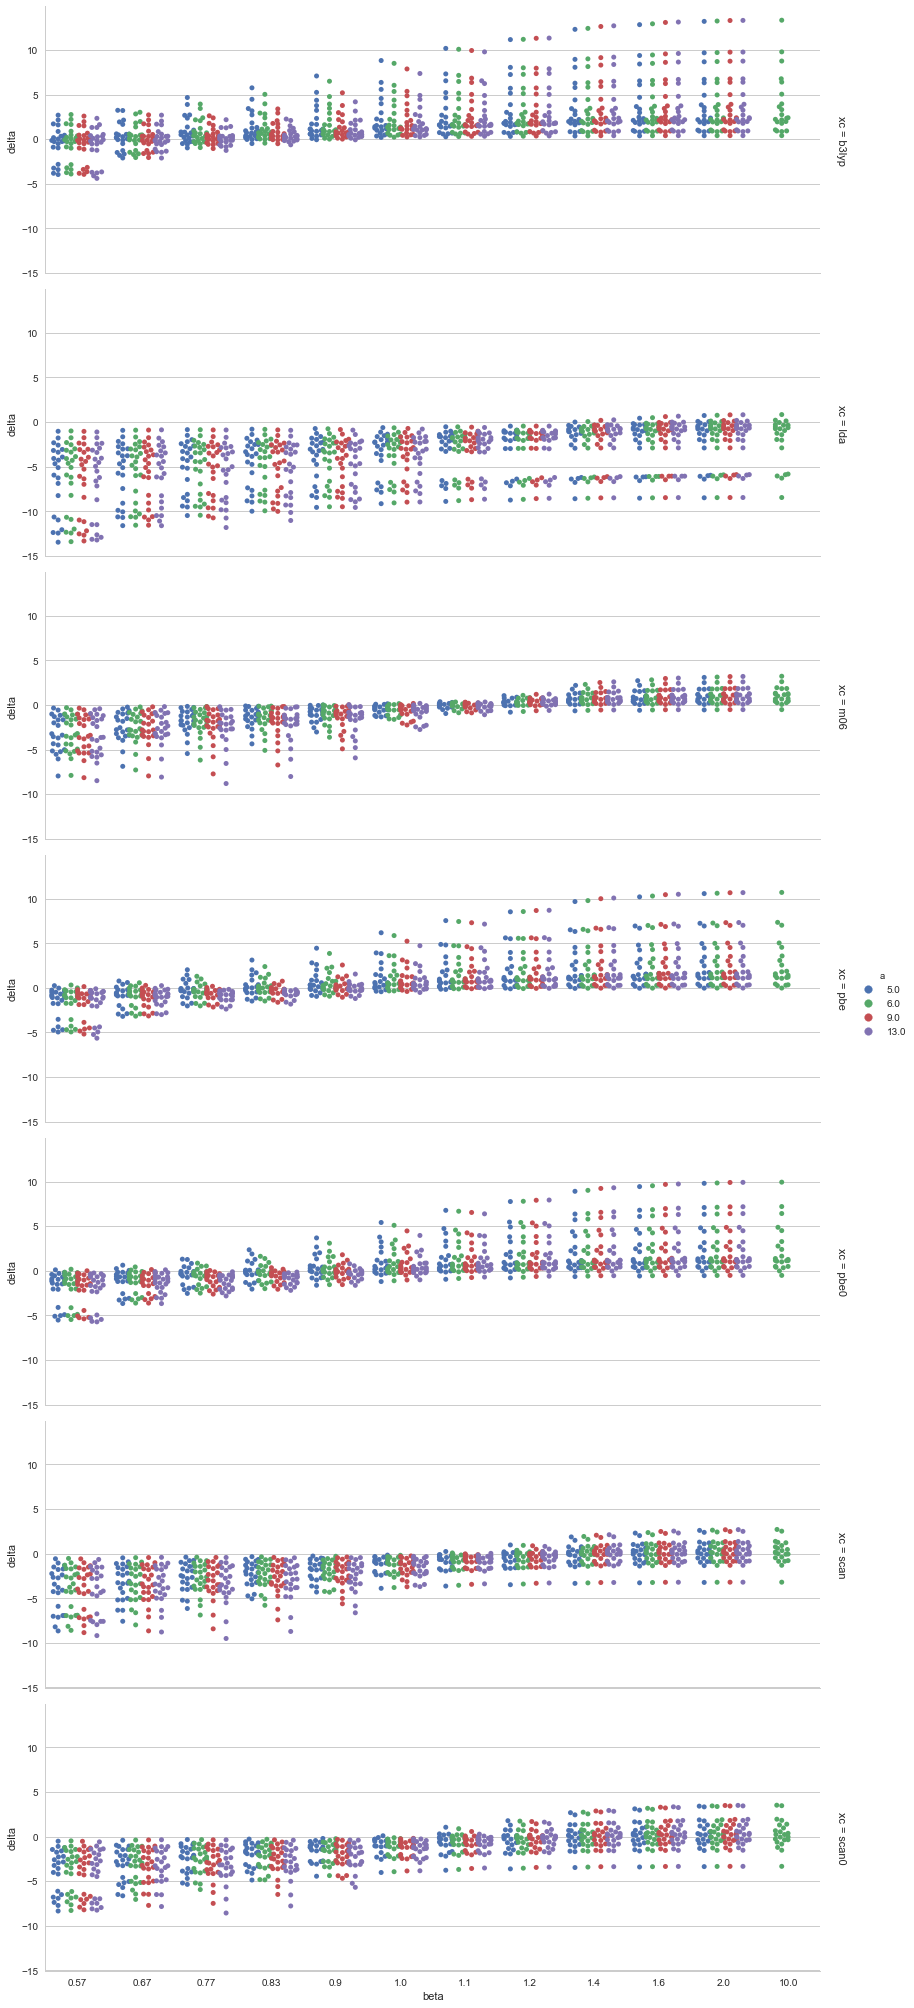

In [10]:
sns.factorplot(
    data=data.loc[(
        'S22',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        [5, 6, 9, 13],
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.]
    ), :].reset_index(),
    kind='swarm',
    x='beta',
    y='delta',
    row='xc',
    hue='a',
    aspect=3,
    split=True,
    margin_titles=True
)

(-1, 1)

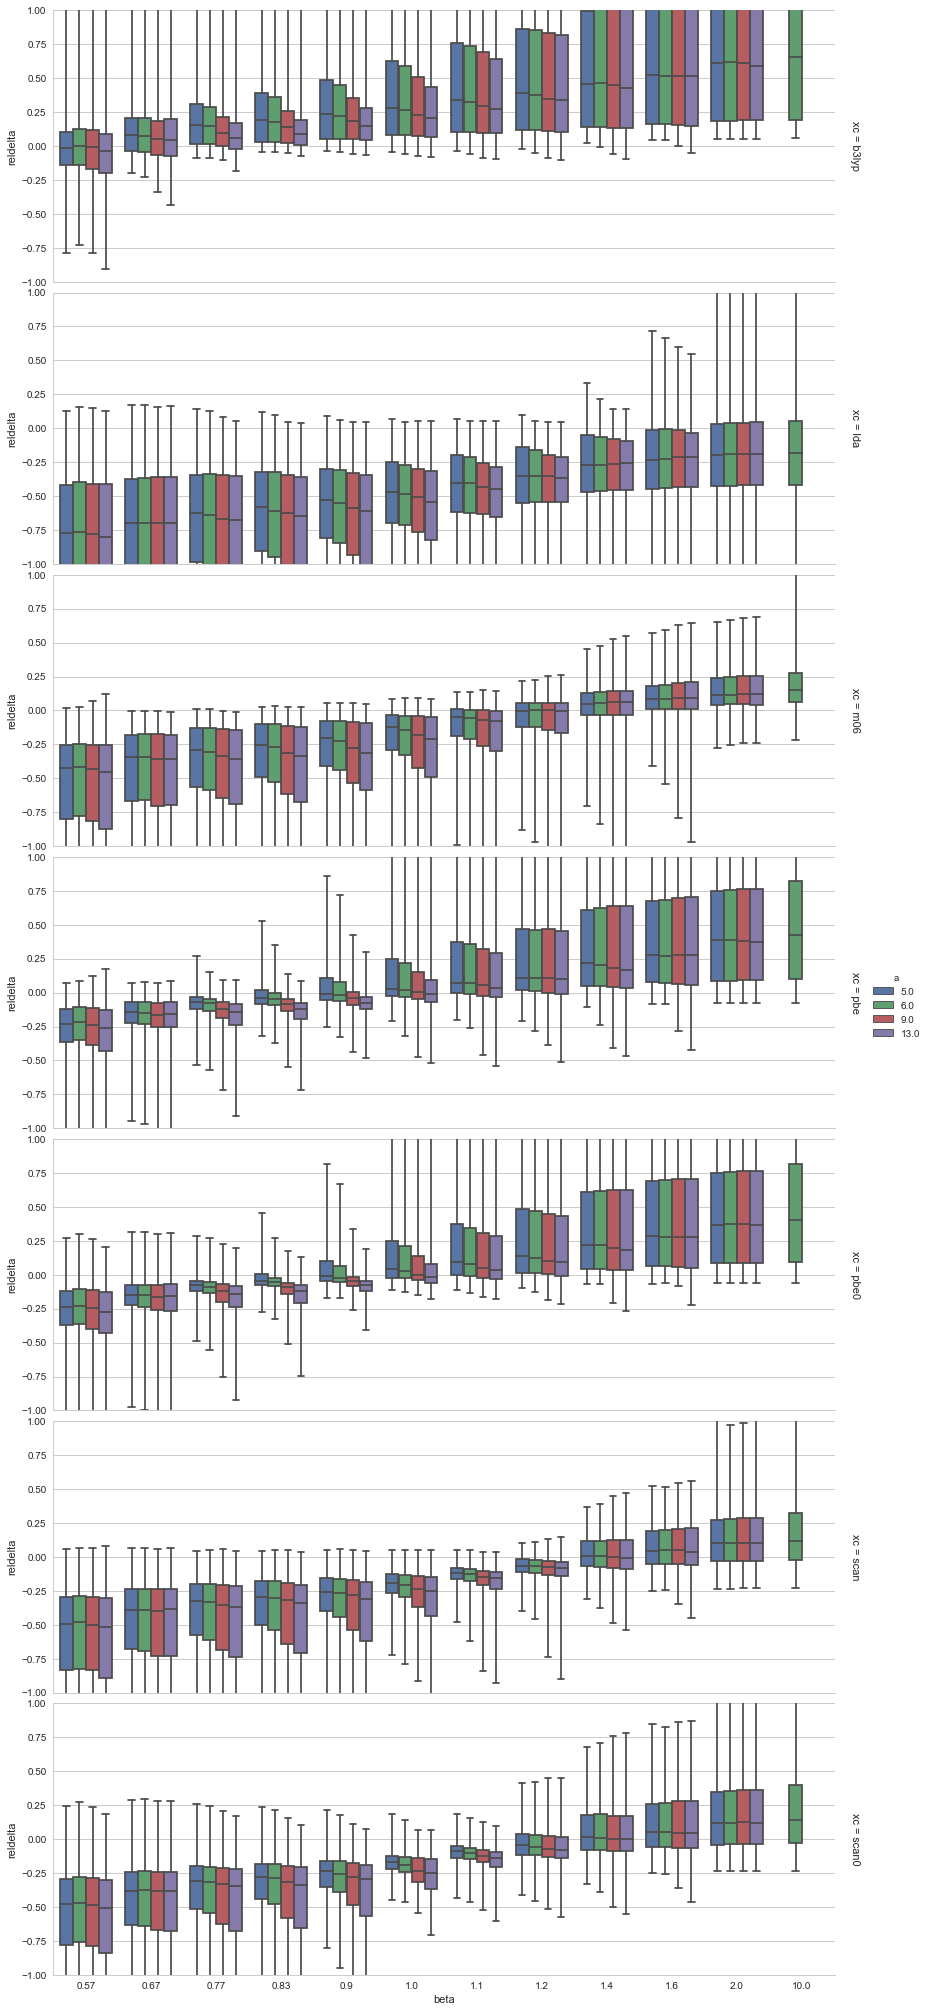

In [11]:
sns.factorplot(
    data=data.loc[(
        'S66x8',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        [5, 6, 9, 13],
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    whis=10,
    row='xc',
    hue='a',
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)

(-1, 1)

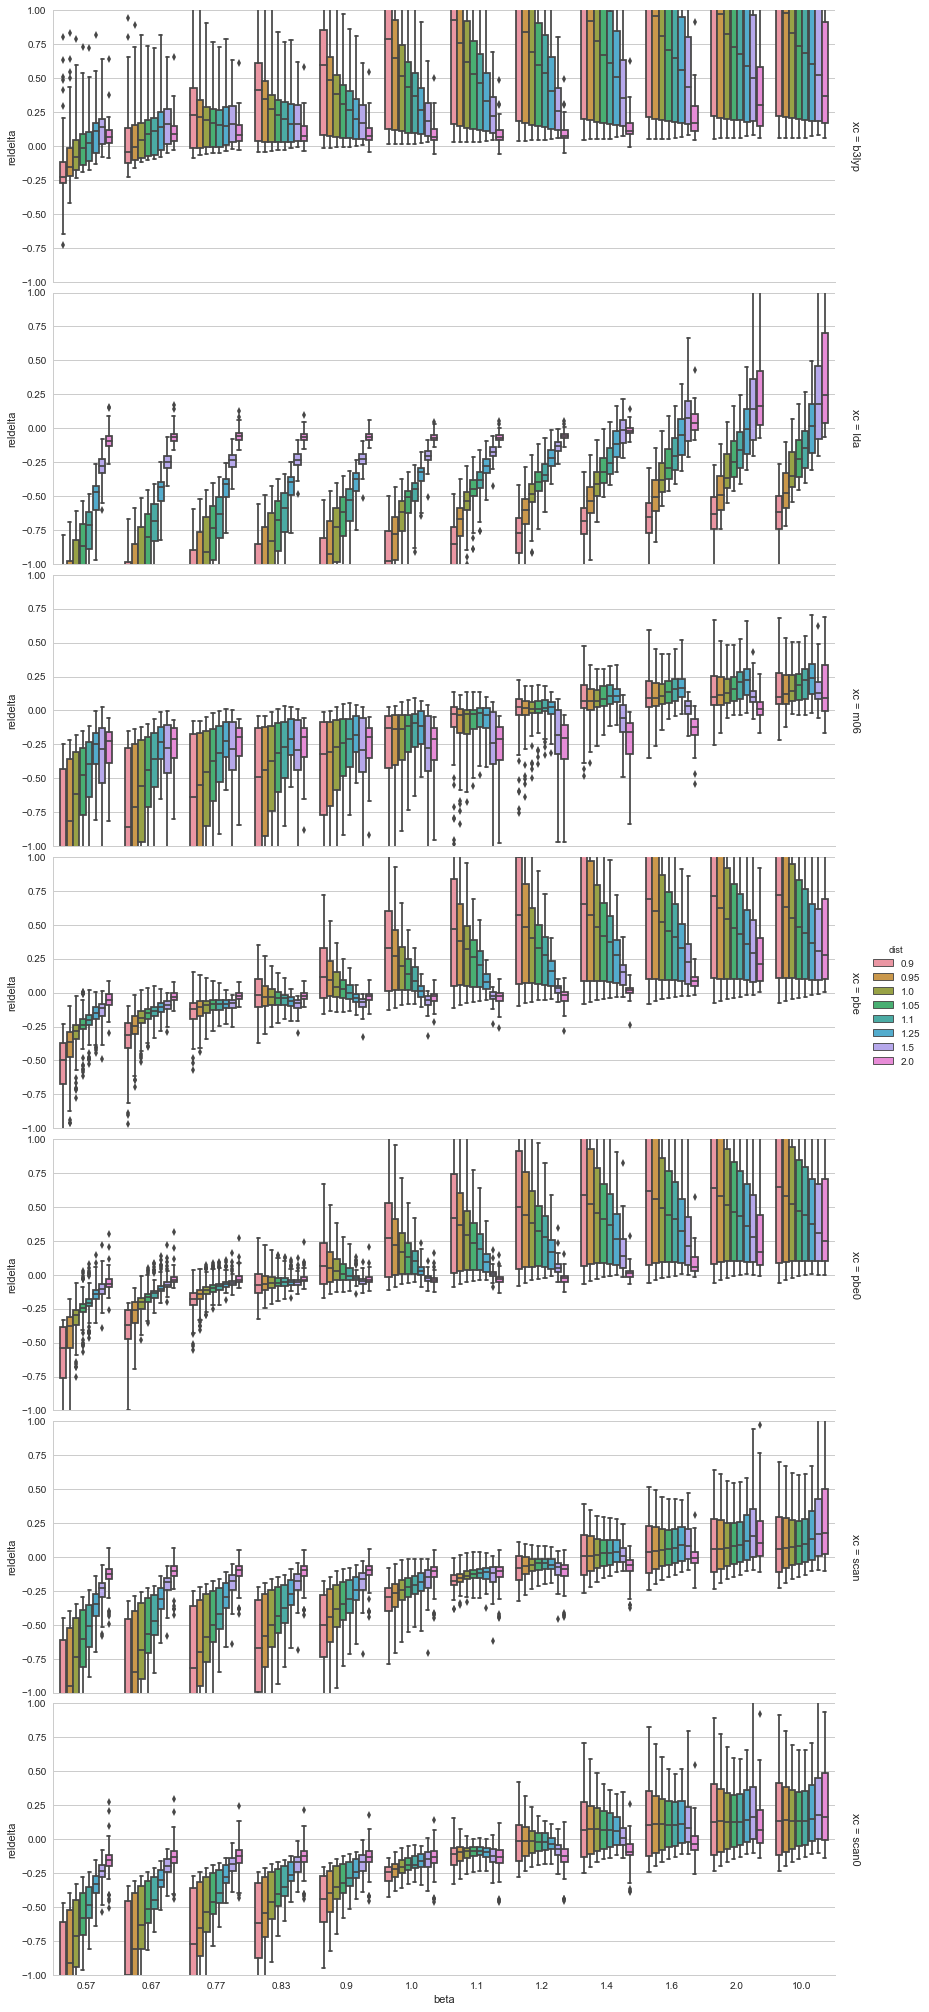

In [12]:
sns.factorplot(
    data=data.loc[(
        'S66x8',
        ['pbe', 'pbe', 'scan', 'scan-light', 'pbe0', 'scan0', 'lda', 'm06', 'm06-light', 'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    row='xc',
    hue='dist',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)

In [13]:
data.loc[('S66x8', 'b3lyp', slice(None), slice(None), 6, .67), :].sort_values('reldelta').iloc[-5:]

ene_scf   ref  natoms  base  \
name  xc    system              dist a   beta                                 
S66x8 b3lyp Benzene ...  Ethene 1.00 6.0 0.67  2.204145 -1.41      18  1.41   
                                1.25 6.0 0.67  0.655588 -0.69      18  0.69   
                                0.95 6.0 0.67  3.279963 -1.13      18  1.41   
                                0.90 6.0 0.67  5.099368 -0.26      18  1.41   
                                1.50 6.0 0.67  0.335828 -0.17      18  0.17   

                                                ene_mbd       ene     delta  \
name  xc    system              dist a   beta                                 
S66x8 b3lyp Benzene ...  Ethene 1.00 6.0 0.67 -2.463853 -0.259708  1.150292   
                                1.25 6.0 0.67 -0.781361 -0.125773  0.564227   
                                0.95 6.0 0.67 -3.149605  0.130358  1.260358   
                                0.90 6.0 0.67 -4.030034  1.069334  1.329334   
                                1.50 6.0 0.67 -0.291828  0.044001  0.214001   

                                               reldelta  
name  xc    system              dist a   beta            
S66x8 b3lyp Benzene ...  Ethene 1.00 6.0 0.67  0.815810  
                                1.25 6.0 0.67  0.817720  
                                0.95 6.0 0.67  0.893871  
                                0.90 6.0 0.67  0.942790  
                                1.50 6.0 0.67  1.258826

In [14]:
data.loc[('S66x8', ['pbe', 'pbe0'], slice(None), 1., 6, .67), 'reldelta'].unstack(1) \
.assign(delta=lambda x: np.abs(x.pbe)-np.abs(x.pbe0)).sort_values('delta').iloc[-5:]

xc                                                       pbe      pbe0  \
name  system                         dist a   beta                       
S66x8 Cyclopentane ...  Cyclopentane 1.0  6.0 0.67 -0.454992 -0.420399   
      Ethene ...  Pentane            1.0  6.0 0.67 -0.432813 -0.397530   
      Ethyne ...  Pentane            1.0  6.0 0.67 -0.376497 -0.338907   
      Benzene ...  Ethene            1.0  6.0 0.67 -0.105193 -0.045194   
      Neopentane ...  Neopentane     1.0  6.0 0.67 -0.485666 -0.414892   

xc                                                     delta  
name  system                         dist a   beta            
S66x8 Cyclopentane ...  Cyclopentane 1.0  6.0 0.67  0.034594  
      Ethene ...  Pentane            1.0  6.0 0.67  0.035283  
      Ethyne ...  Pentane            1.0  6.0 0.67  0.037590  
      Benzene ...  Ethene            1.0  6.0 0.67  0.059999  
      Neopentane ...  Neopentane     1.0  6.0 0.67  0.070774

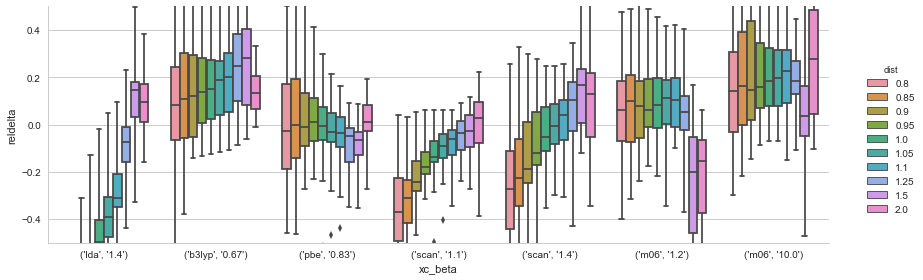

In [15]:
sns.factorplot(
    data=pd.concat([
        data.loc[('X40x10', 'lda', slice(None), slice(None), 6, 1.4), :].reset_index(),
        data.loc[('X40x10', 'b3lyp', slice(None), slice(None), 6, .67), :].reset_index(),
        data.loc[('X40x10', 'pbe', slice(None), slice(None), 6, .83), :].reset_index(),
        data.loc[('X40x10', 'scan', slice(None), slice(None), 6, 1.1), :].reset_index(),
        data.loc[('X40x10', 'scan', slice(None), slice(None), 6, 1.4), :].reset_index(),
        data.loc[('X40x10', 'm06', slice(None), slice(None), 6, 1.2), :].reset_index(),
        data.loc[('X40x10', 'm06', slice(None), slice(None), 6, 10.), :].reset_index(),
    ]).assign(xc_beta=lambda x: list(zip(x['xc'], x['beta'].astype(str)))),
    kind='box',
    x='xc_beta',
    y='reldelta',
    hue='dist',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-.5, .5)
savefig('x40-dists')

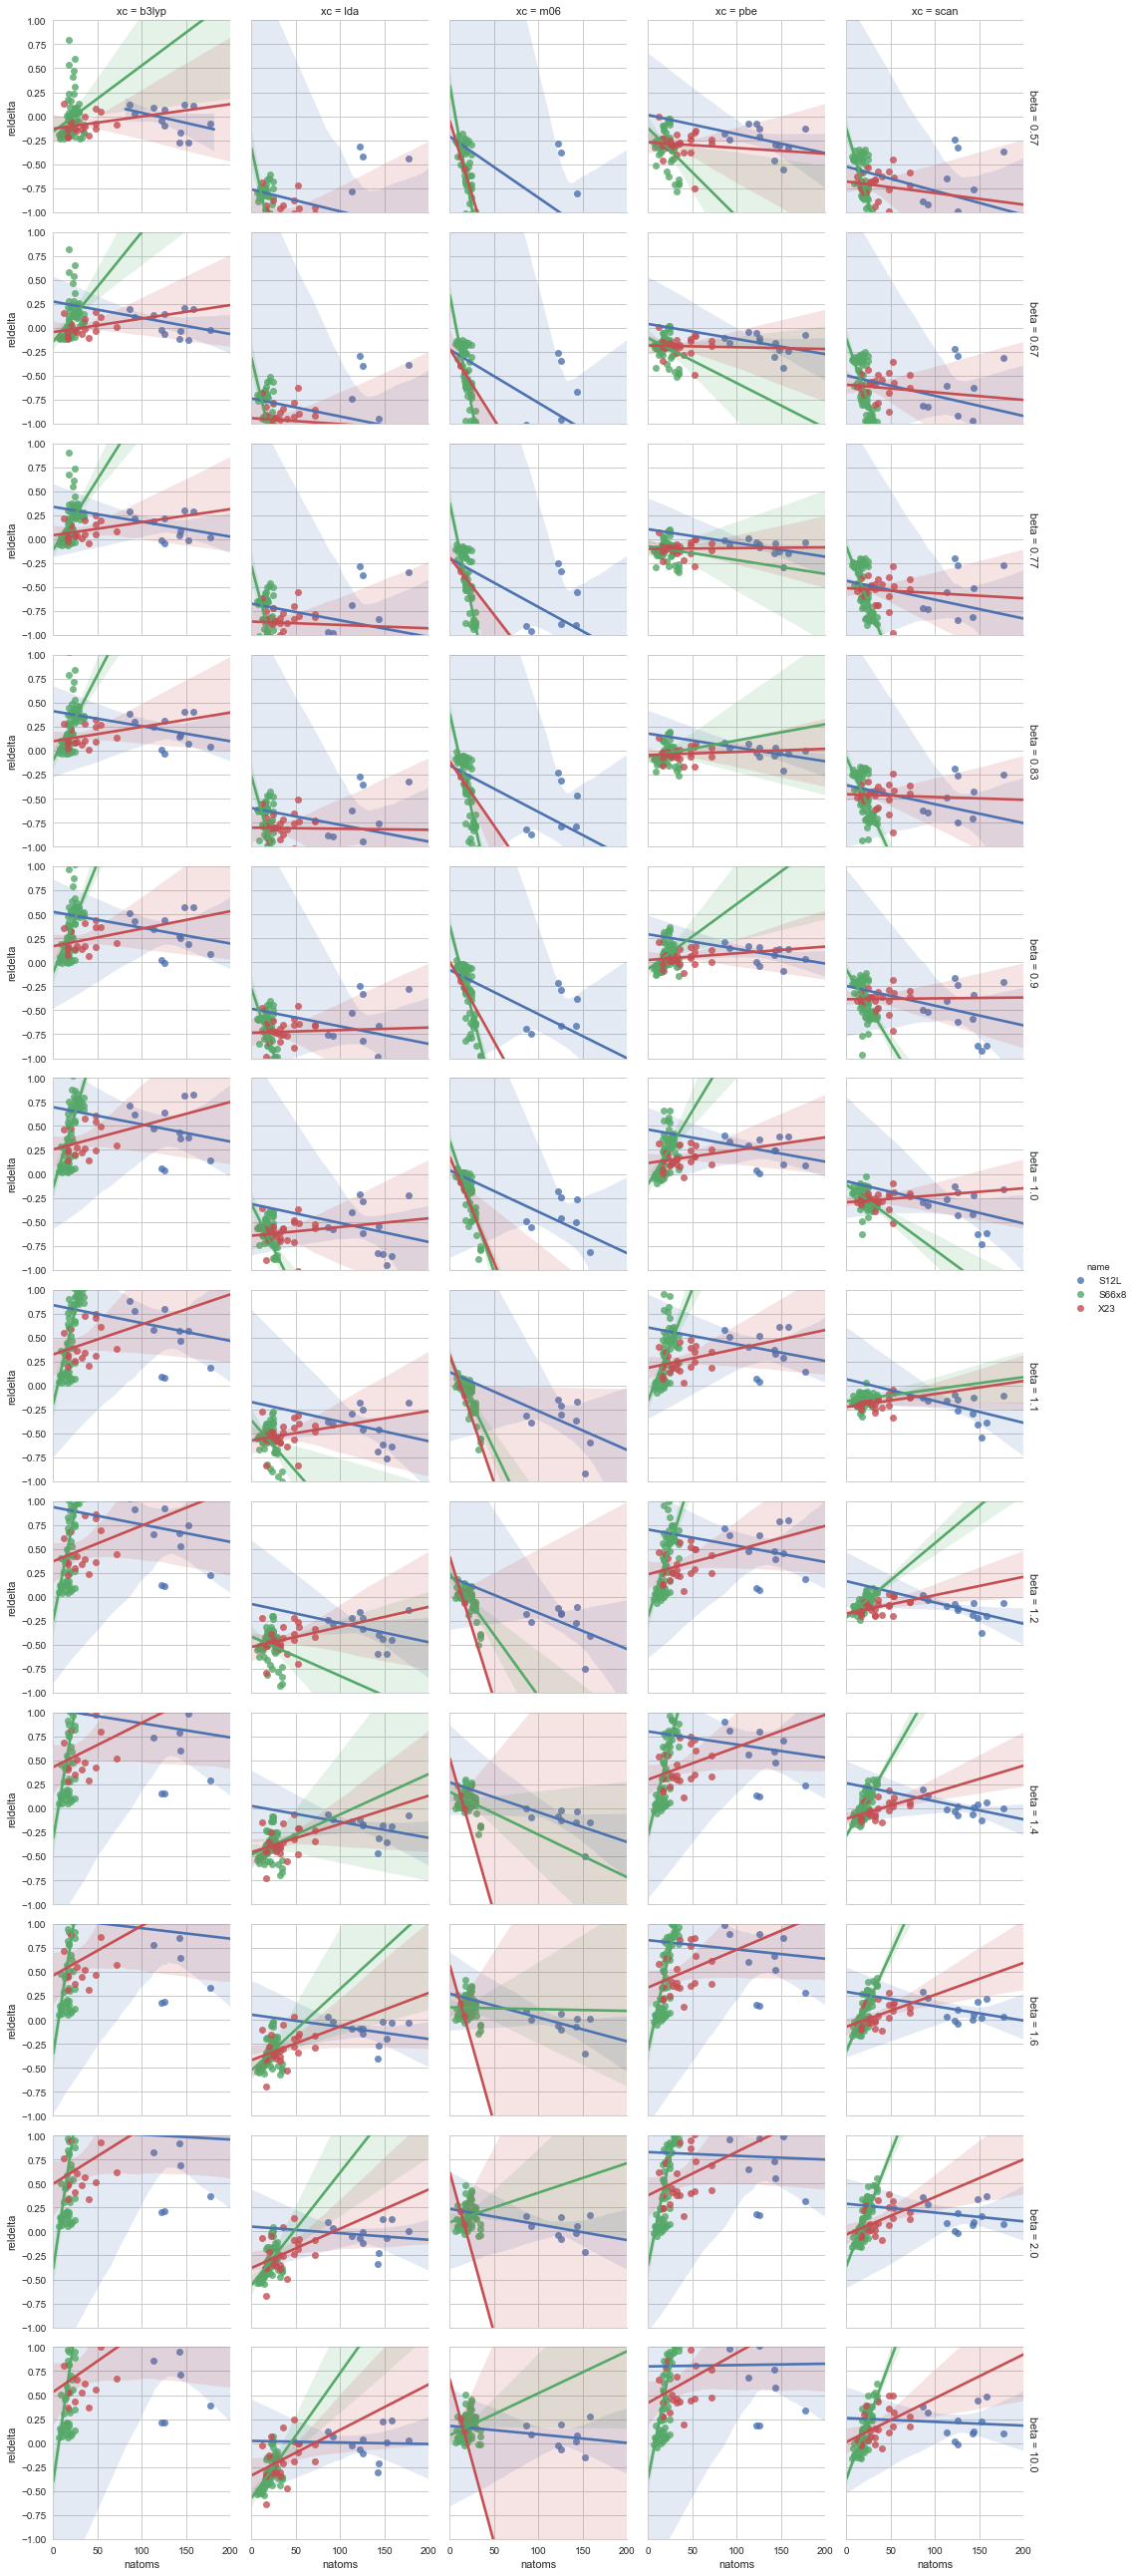

In [16]:
def regplot(*args, **kwargs):
    sns.regplot(*args, **kwargs)
    sns.plt.xlim(0, 200)
    sns.plt.ylim(-1, 1)
    
sns.FacetGrid(
    data=data.loc[(
        ['S66x8', 'S12L', 'X23'],
        ['pbe', 'scan', 'lda', 'm06', 'b3lyp'],
        slice(None),
        1.,
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    row='beta',
    col='xc',
    hue='name',
    margin_titles=True
).map(regplot, 'natoms', 'reldelta').add_legend()

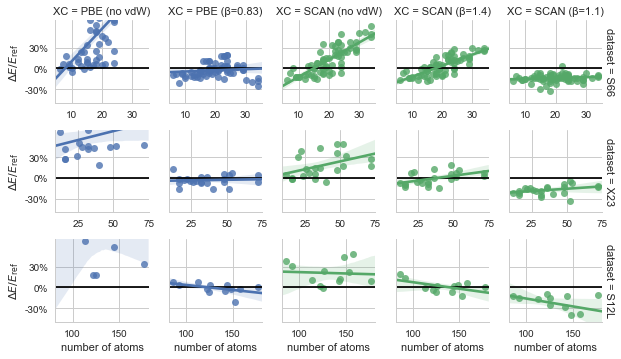

In [17]:
def regplot(*args, **kwargs):
    sns.plt.axhline(color='black')
    # sns.kdeplot(*args, **kwargs, n_levels=5)
    sns.regplot(*args, **kwargs)
    
def get_name(row):
    name = row['xc'].upper()
    name += f' (β={row["beta"]})' if row['beta'] != 10. else ' (no vdW)'
    return name

g = sns.FacetGrid(
    data=pd.concat([
        data.loc[(['S66x8', 'S12L', 'X23'], 'pbe', slice(None), 1., 6, 10.), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'pbe', slice(None), 1., 6, .83), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'scan', slice(None), 1., 6, 10.), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'scan', slice(None), 1., 6, 1.4), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'scan', slice(None), 1., 6, 1.1), :].reset_index(),
    ]).assign(XC=lambda x: x.apply(get_name, axis=1))
    .rename(columns={'natoms': 'number of atoms', 'name': 'dataset'})
    .replace('S66x8', 'S66'),
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    hue='xc',
    size=1.7,
    margin_titles=True,
    sharex=False,
).map(regplot, 'number of atoms', 'reldelta')
g.fig.subplots_adjust(left=0.08)
sns.plt.ylim(-.5, .7)
# g.set_xlabels(r'$\beta$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
yticks = [-.3, 0, .3]
g.set(yticks=yticks)
# g.set_xticklabels(xticks)
g.set_yticklabels(['-30%', '0%', '30%'])
savefig('size-dependence-2')

(-2, 2)

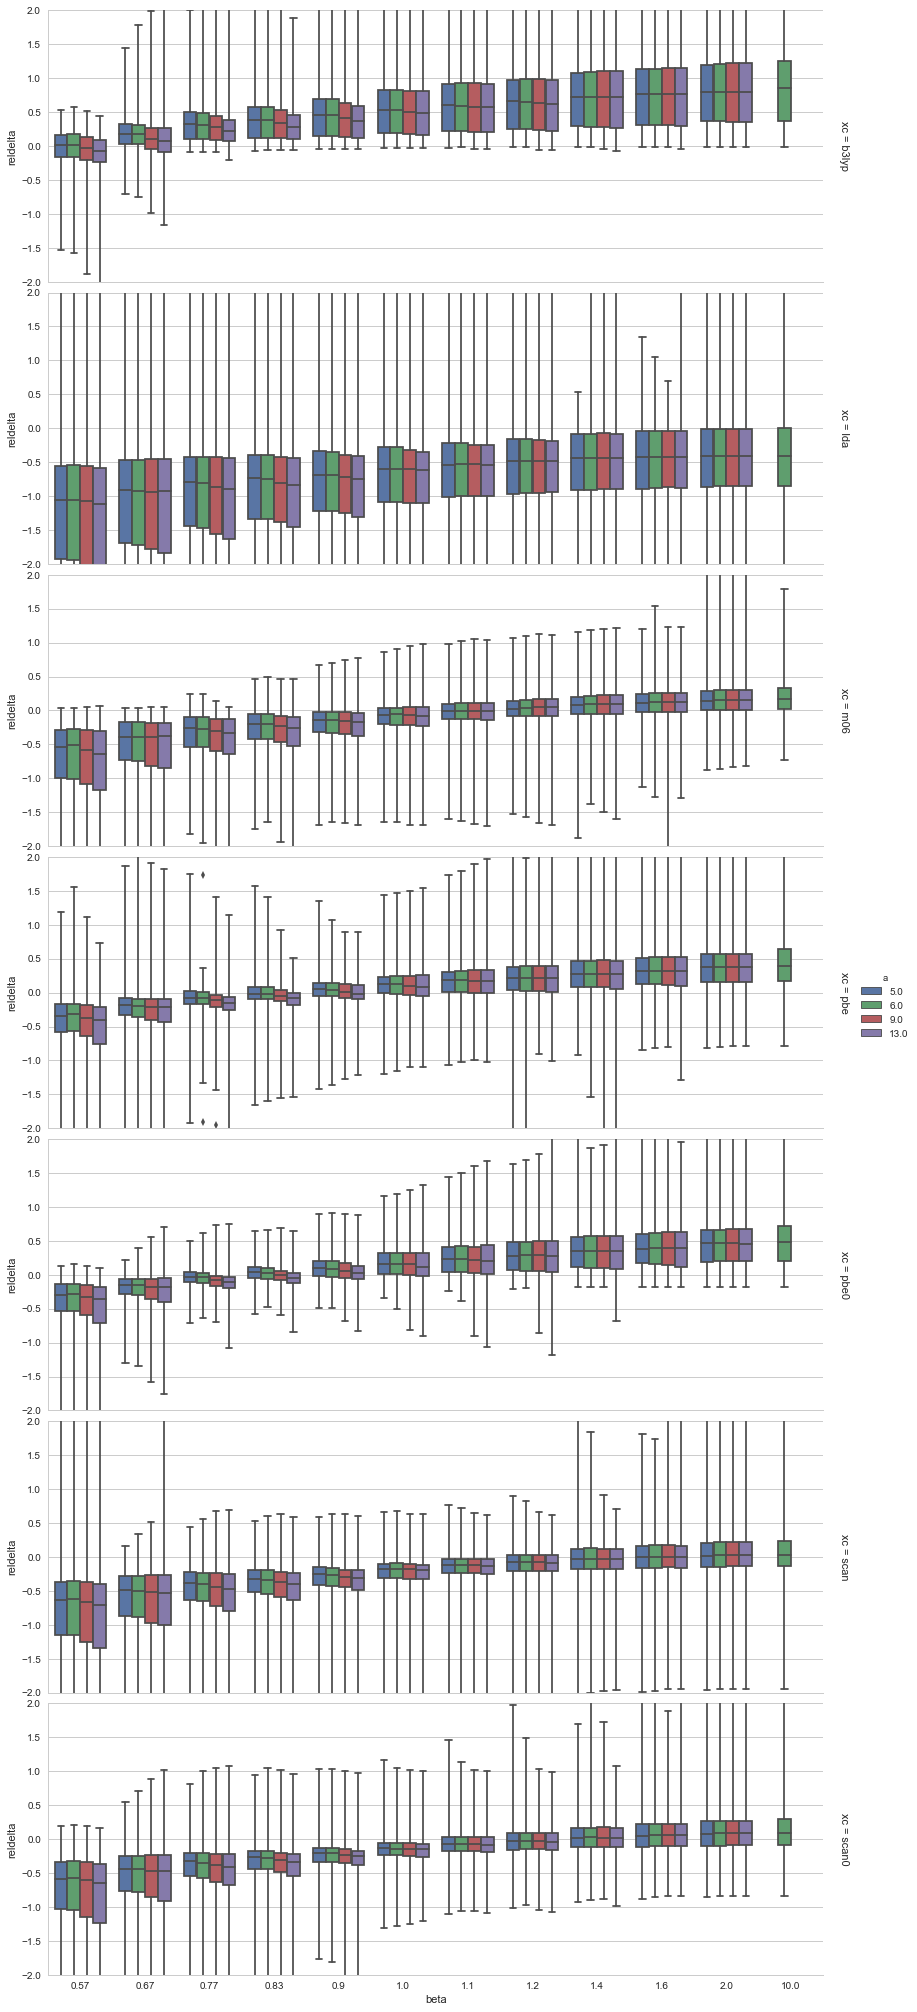

In [18]:
sns.factorplot(
    data=data.loc[(
        'X40x10',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        [5, 6, 9, 13],
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    whis=10,
    row='xc',
    hue='a',
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-2, 2)

(-1, 1)

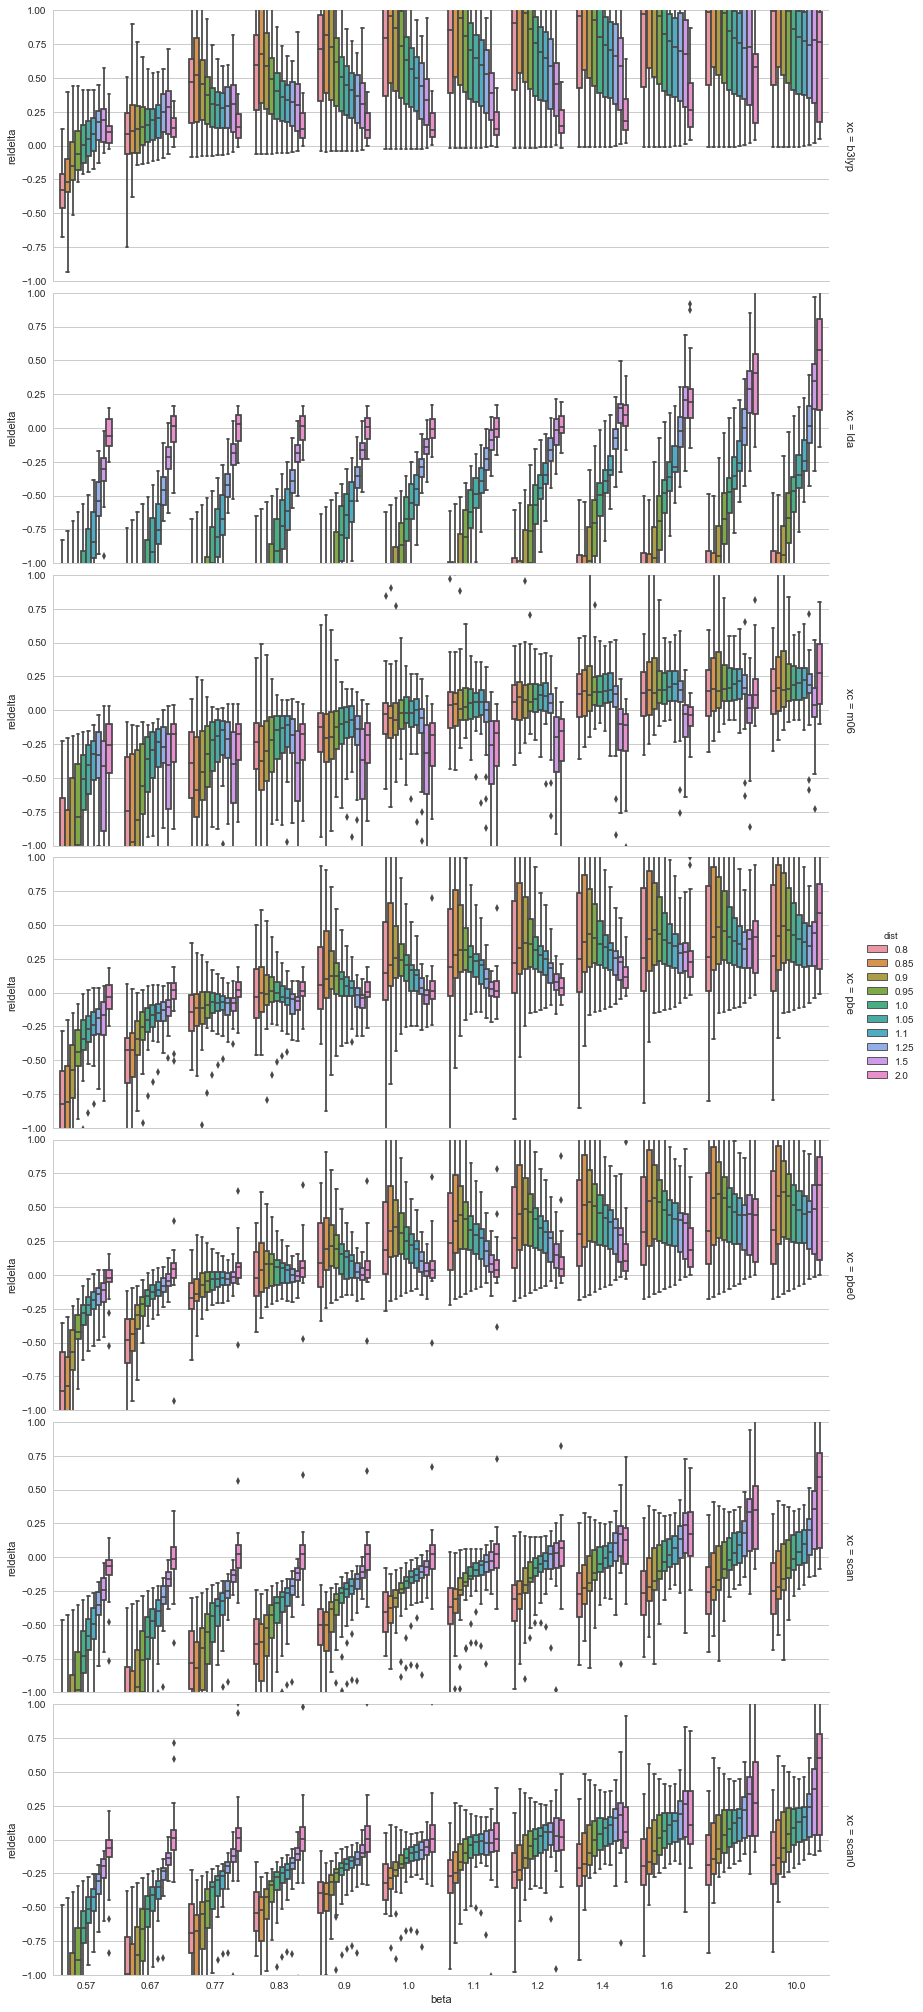

In [19]:
sns.factorplot(
    data=data.loc[(
        'X40x10',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    row='xc',
    hue='dist',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)

(-0.6, 0.6)

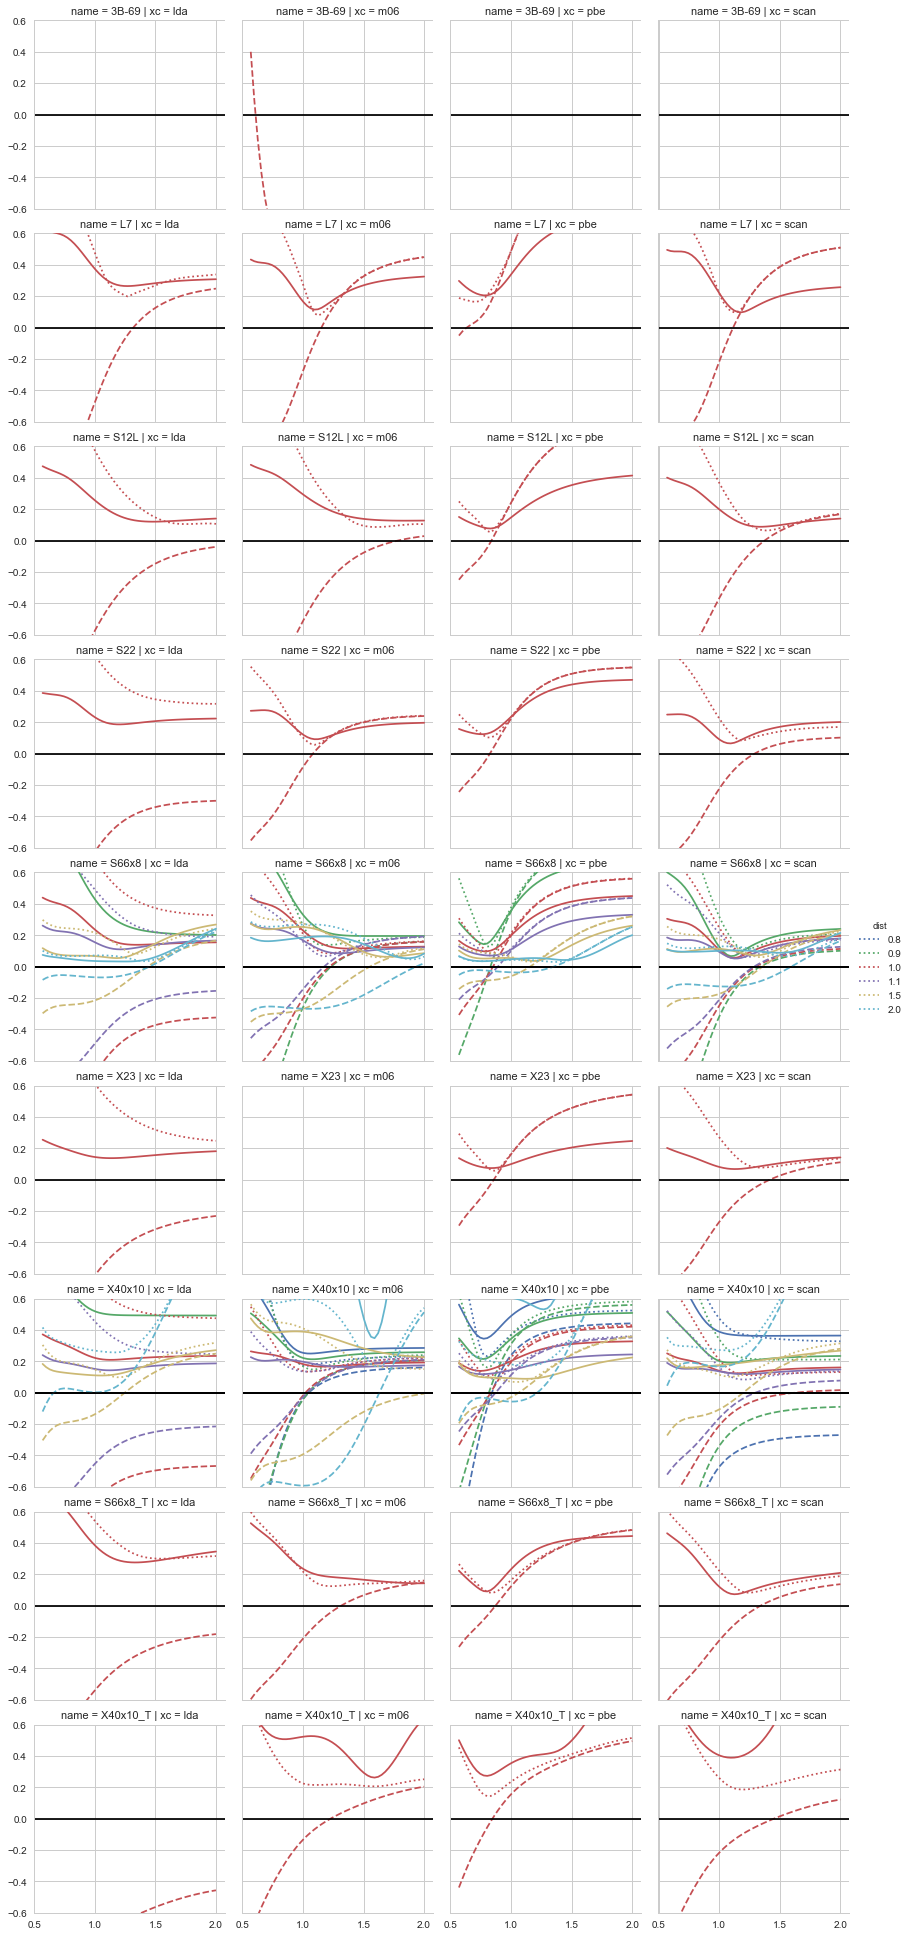

In [20]:
sns.FacetGrid(
    data=pd.concat([
        data.loc[(
            slice(None, 'X40x10'),
            ['pbe', 'scan', 'm06', 'm06-light', 'lda'],
            slice(None),
            [.8, .9, 1., 1.1, 1.5, 2.],
            6,
            slice(None, 2.)
        ), :].reset_index(),
        data.loc[(
            ['X40x10', 'S66x8'],
            ['pbe', 'scan', 'm06', 'm06-light', 'lda'],
            slice(None),
            slice(None),
            6,
            slice(None, 2.)
        ), :].reset_index().pipe(zero_dist)
    ])
    .loc[
        lambda x: (x['name'] == 'X23') & (x['xc'] == 'm06-light') |
            (x['name'] != 'X23') & (x['xc'] == 'm06') | ~x['xc'].str.contains('m06')
    ].replace('m06-light', 'm06'),
    row='name',
    col='xc',
    hue='dist'
).map_dataframe(plot_stat).add_legend()
sns.plt.ylim(-.6, .6)

In [21]:
data.loc['S22', 'scan', slice(None), 1., 6, .57]

ene_scf  \
name xc   system                               dist a   beta              
S22  scan 2-pyridoxine 2-aminopyridine complex 1.0  6.0 0.57 -17.490298   
          Adenine thymine Watson-Crick complex 1.0  6.0 0.57 -16.754051   
          Adenine thymine complex stack        1.0  6.0 0.57  -9.710394   
          Ammonia dimer                        1.0  6.0 0.57  -3.240660   
          Benzene - Methane complex            1.0  6.0 0.57  -1.034211   
          Benzene HCN complex                  1.0  6.0 0.57  -4.510991   
          Benzene ammonia complex              1.0  6.0 0.57  -2.230574   
          Benzene dimer T-shaped               1.0  6.0 0.57  -1.832995   
          Benzene dimer parallel displaced     1.0  6.0 0.57  -1.353309   
          Benzene water complex                1.0  6.0 0.57  -3.742754   
          Ethene dimer                         1.0  6.0 0.57  -1.169081   
          Ethene ethyne complex                1.0  6.0 0.57  -1.541698   
          Formamide dimer                      1.0  6.0 0.57 -17.265414   
          Formic acid dimer                    1.0  6.0 0.57 -21.806903   
          Indole benzene T-shape complex       1.0  6.0 0.57  -4.508021   
          Indole benzene complex stack         1.0  6.0 0.57  -2.507800   
          Methane dimer                        1.0  6.0 0.57  -0.356418   
          Phenol dimer                         1.0  6.0 0.57  -6.450126   
          Pyrazine dimer                       1.0  6.0 0.57  -3.154784   
          Uracil dimer h-bonded                1.0  6.0 0.57 -21.322876   
          Uracil dimer stack                   1.0  6.0 0.57  -9.114015   
          Water dimer                          1.0  6.0 0.57  -5.881848   

                                                                ref  natoms  \
name xc   system                               dist a   beta                  
S22  scan 2-pyridoxine 2-aminopyridine complex 1.0  6.0 0.57 -16.71      25   
          Adenine thymine Watson-Crick complex 1.0  6.0 0.57 -16.37      30   
          Adenine thymine complex stack        1.0  6.0 0.57 -12.23      30   
          Ammonia dimer                        1.0  6.0 0.57  -3.17       8   
          Benzene - Methane complex            1.0  6.0 0.57  -1.50      17   
          Benzene HCN complex                  1.0  6.0 0.57  -4.46      15   
          Benzene ammonia complex              1.0  6.0 0.57  -2.35      16   
          Benzene dimer T-shaped               1.0  6.0 0.57  -2.74      24   
          Benzene dimer parallel displaced     1.0  6.0 0.57  -2.73      24   
          Benzene water complex                1.0  6.0 0.57  -3.28      15   
          Ethene dimer                         1.0  6.0 0.57  -1.51      12   
          Ethene ethyne complex                1.0  6.0 0.57  -1.53      10   
          Formamide dimer                      1.0  6.0 0.57 -15.96      12   
          Formic acid dimer                    1.0  6.0 0.57 -18.61      10   
          Indole benzene T-shape complex       1.0  6.0 0.57  -5.73      28   
          Indole benzene complex stack         1.0  6.0 0.57  -5.22      28   
          Methane dimer                        1.0  6.0 0.57  -0.53      10   
          Phenol dimer                         1.0  6.0 0.57  -7.05      26   
          Pyrazine dimer                       1.0  6.0 0.57  -4.42      20   
          Uracil dimer h-bonded                1.0  6.0 0.57 -20.47      24   
          Uracil dimer stack                   1.0  6.0 0.57  -9.88      24   
          Water dimer                          1.0  6.0 0.57  -5.02       6   

                                                               base  \
name xc   system                               dist a   beta          
S22  scan 2-pyridoxine 2-aminopyridine complex 1.0  6.0 0.57  16.71   
          Adenine thymine Watson-Crick complex 1.0  6.0 0.57  16.37   
          Adenine thymine complex stack        1.0  6.0 0.57  12.23   
          A

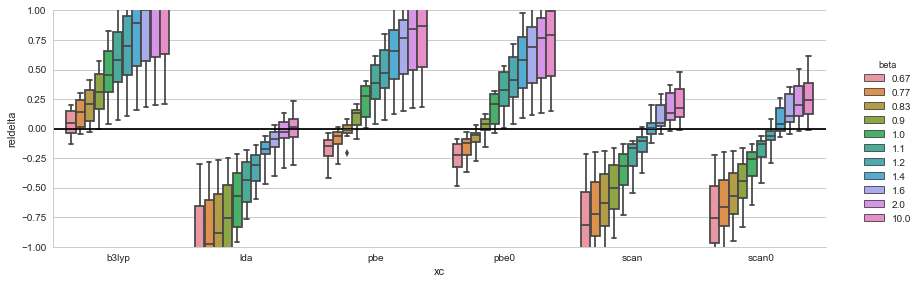

In [22]:
sns.factorplot(
    data=data.loc[(
        'S12L',
        ['pbe',
         'pbe0',
         'scan',
         'scan0',
         'lda',
         'm06-light',
         'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index().replace({'m06-light': 'm06'}),
    kind='box',
    x='xc',
    y='reldelta',
    hue='beta',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)
sns.plt.axhline(color='black')
savefig('x23-beta')

In [23]:
def get_optimal_beta(df):
    df = df.groupby(level='beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    mare = interp1d(df['beta'], df['MARE'], kind='cubic')
    mae = interp1d(df['beta'], df['MAE'], kind='cubic')
    res = minimize(mare, 1., bounds=[(df['beta'].min(), df['beta'].min())])
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    opt_mare = minimize(mare, 1.6, bounds=bounds).x[0]
    opt_mae = minimize(mae, 1.6, bounds=bounds).x[0]
    return pd.Series({
        (q1, q2): np.round(fnc(val), 2)
        for q1, val in zip('mean STD MARE'.split(), [opt_mean, opt_std, opt_mare])
        for q2, fnc in zip('beta mean STD MARE MAE'.split(), [lambda x: x, mean, std, mare, mae])
    })

colors = {'MAE': 'blue', 'MARE': 'green', 'beta': 'blac', 'mean': 'red', 'STD': 'violet'}

def styler(col):
    return len(col)*[f'color: {colors[col.name[1]]}']
    
data.loc[(
    slice(None, 'X40x10'),
    ['pbe', 'scan', 'm06', 'b3lyp', 'pbe0', 'lda'],
    slice(None),
    slice(None),
    6,
    slice(None, 2.)
), :].groupby(level='xc name'.split()) \
.apply(get_optimal_beta).style.apply(styler)

(-0.7, 0.1)

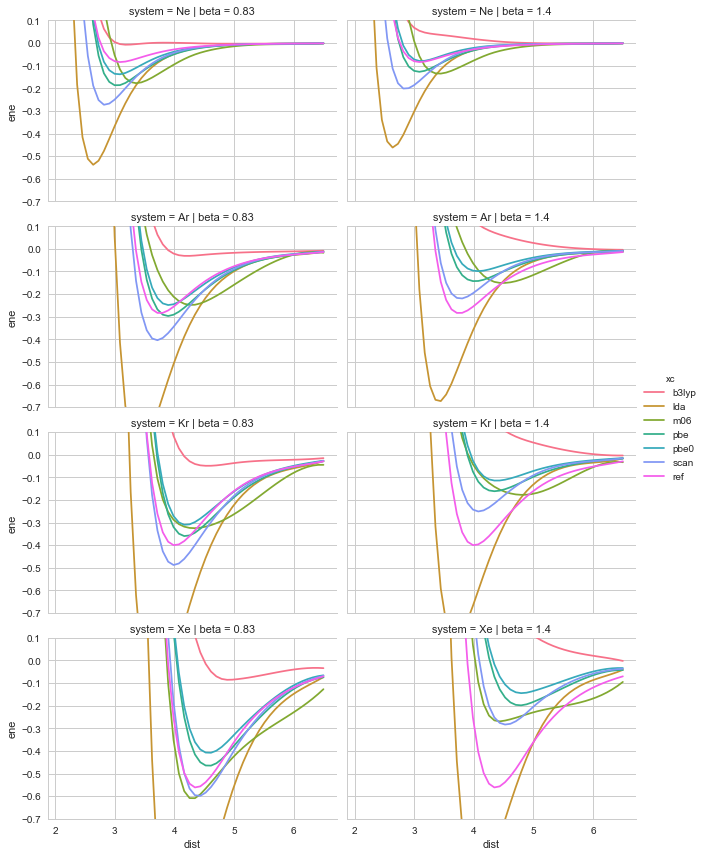

In [24]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'ref'
    df['ene'] = df['ref']
    return df

def plot_curve(x, y, **kwargs):
    yinp  = interp1d(x, y, kind='cubic')
    xfine = np.linspace(x.min(), x.max())
    sns.plt.plot(xfine, yinp(xfine), **kwargs)
    
sns.FacetGrid(
    data=pd.concat([
        data.loc[(
            'rare-gas',
            ['pbe', 'pbe0', 'scan', 'm06', 'lda', 'b3lyp'],
            slice(None),
            slice(None, 7.),
            6,
            [.83, 1.4]
        ), :].reset_index(),
        data.loc[(
            'rare-gas', 'pbe', slice(None), slice(None, 7.), 6,
            [.83, 1.4]
        )].reset_index().pipe(replace_ref)
    ]),
    col='beta',
    row='system',
    row_order=['Ne', 'Ar', 'Kr', 'Xe'],
    hue='xc',
    aspect=1.5,
).map(plot_curve, 'dist', 'ene').add_legend()
sns.plt.ylim(-.7, .1)

In [25]:
data.loc[(
    'L7',
    ['pbe', 'pbe0', 'scan', 'm06', 'lda', 'b3lyp'],
    slice(None),
    slice(None),
    6,
    10.
), :].groupby(level='xc').apply(get_stat)

MAE      MARE       STD      mean
xc                                            
b3lyp  22.824454  1.596630  0.985348  1.596630
lda     6.102576  0.355163  0.315043  0.286323
m06     6.880348  0.487029  0.343141  0.487029
pbe    18.538875  1.253420  0.729949  1.253420
pbe0   17.986207  1.244114  0.761086  1.244114
scan    8.441675  0.547752  0.276054  0.547752

## D3 (BJ)

In [26]:
def cross_join(df, name, col):
    return df.assign(_key=0).merge(pd.DataFrame({name: col, '_key': 0}), on='_key').drop('_key', axis=1)

In [27]:
def merge_scf_vdw(baseidx, scf, scfidx, vdw, vdwidx, params):
    data = pd.merge(
        scf.loc[baseidx + scfidx, :].reset_index(),
        vdw.loc[baseidx + vdwidx, :].reset_index(),
        on='name system dist'.split(),
        how='inner',
        suffixes=('_scf', '_vdw')
    )
    data.set_index('name xc system dist'.split() + params, inplace=True)
    data['ene'] = data['ene_scf']+data['ene_vdw']
    data['delta'] = data['ene']-data['ref']
    data['reldelta'] = data['delta']/data['base']
    return data

In [28]:
def merge_scf_vdw_multi(baseidx, scf, scfidxs, vdw, vdwidxs, params):
    data = pd.merge(
        pd.concat(scf.loc[baseidx + idx, :] for idx in scfidxs).reset_index(),
        pd.concat(vdw.loc[baseidx + idx, :] for idx in vdwidxs).reset_index(),
        on='name system dist'.split(),
        how='inner',
        suffixes=('_scf', '_vdw')
    )
    data.set_index('name xc system dist'.split() + params, inplace=True)
    data['ene'] = data['ene_scf']+data['ene_vdw']
    data['delta'] = data['ene']-data['ref']
    data['reldelta'] = data['delta']/data['base']
    return data

In [29]:
data_scf.index.names, data_dftd3_bj.index.names

(FrozenList(['name', 'system', 'dist', 'xc']),
 FrozenList(['name', 'system', 'dist', 'a1', 'a2', 's8']))

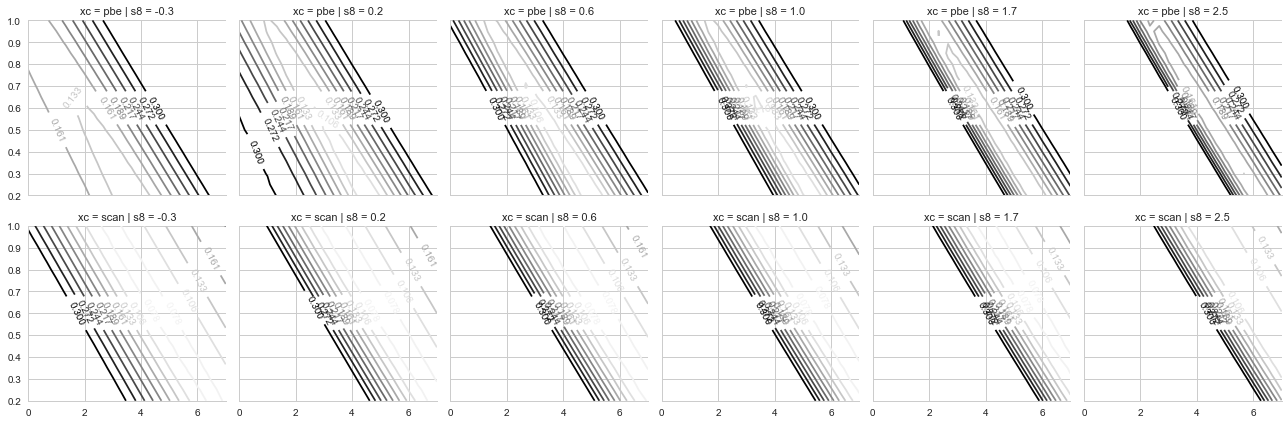

In [30]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a1 a2'.split()).apply(get_stat)
    df = df.reset_index().pivot(index='a1', columns='a2', values='STD')
    mare = df.as_matrix()
    p = sns.plt.contour(df.columns, df.index, mare, np.linspace(0.05, 0.3, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_bj, (slice(None), slice(None, 7.), slice(None, None, 2)),
        'a1 a2 s8'.split()
    ).reset_index(),
    col='s8',
    row='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()

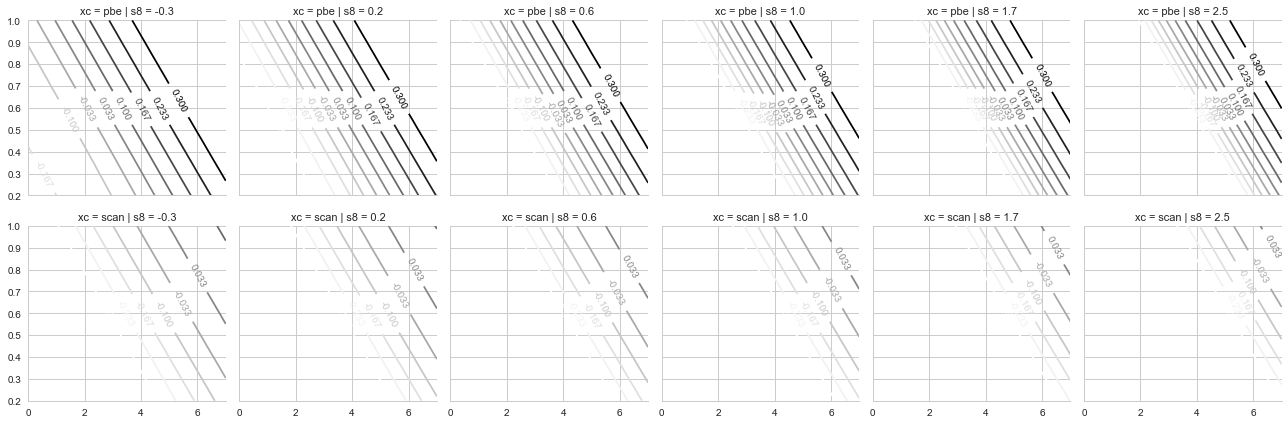

In [31]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a1 a2'.split()).apply(get_stat)
    df = df.reset_index().pivot(index='a1', columns='a2', values='mean')
    mat = df.as_matrix()
    p = sns.plt.contour(df.columns, df.index, mat, np.linspace(-.3, .3, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_bj, (slice(None), slice(None, 7.), slice(None, None, 2)),
        'a1 a2 s8'.split()
    ).reset_index(),
    col='s8',
    row='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()

In [32]:
data_dftd3_bj.reset_index().s8.unique()

array([-0.3,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.3,  1.7,  2. ,  2.5,
        3. ])

(-0.4, 0.4)

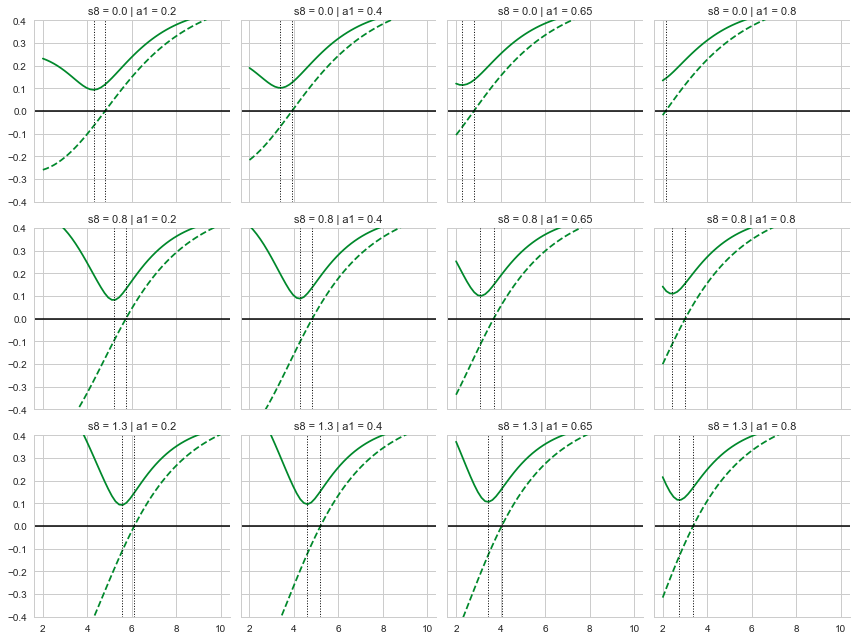

In [33]:
def plot_stat(**kwargs):
    df = kwargs.pop('data')
    df = df.groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

In [34]:
def subtract_abc(df):
    df = df.copy()
    df['ene'] = df['ene']-df['ene3']
    return df

(-0.4, 0.4)

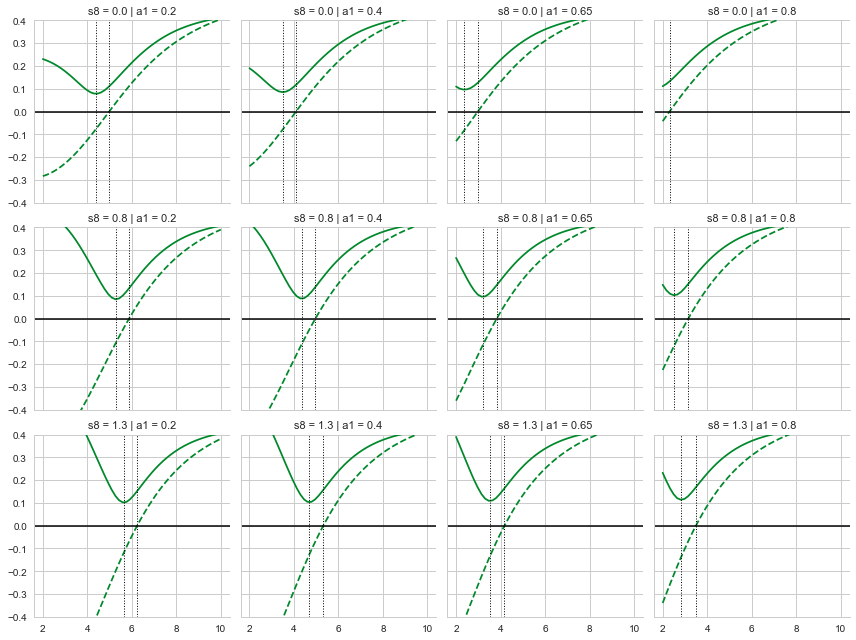

In [35]:
def plot_stat(**kwargs):
    df = kwargs.pop('data')
    df = df.groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

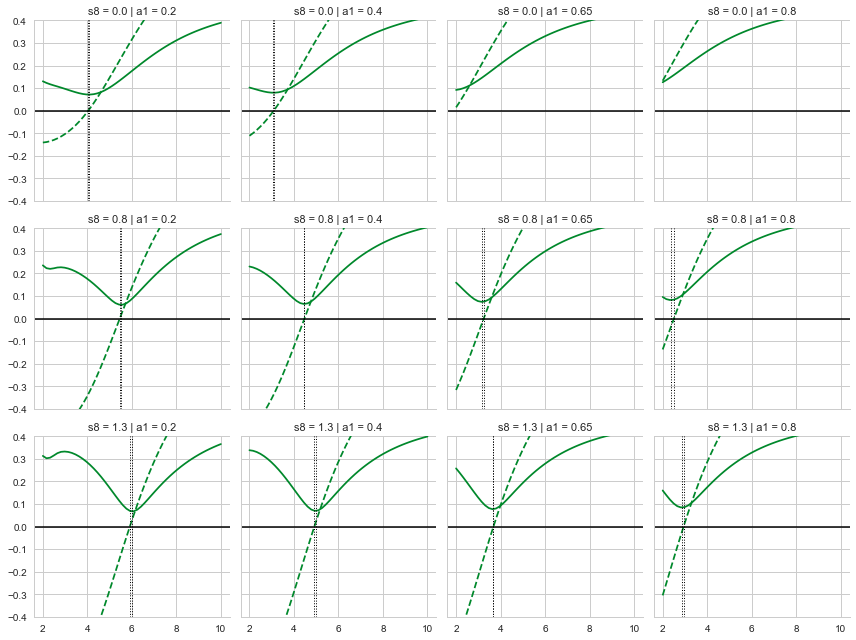

In [36]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)


g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

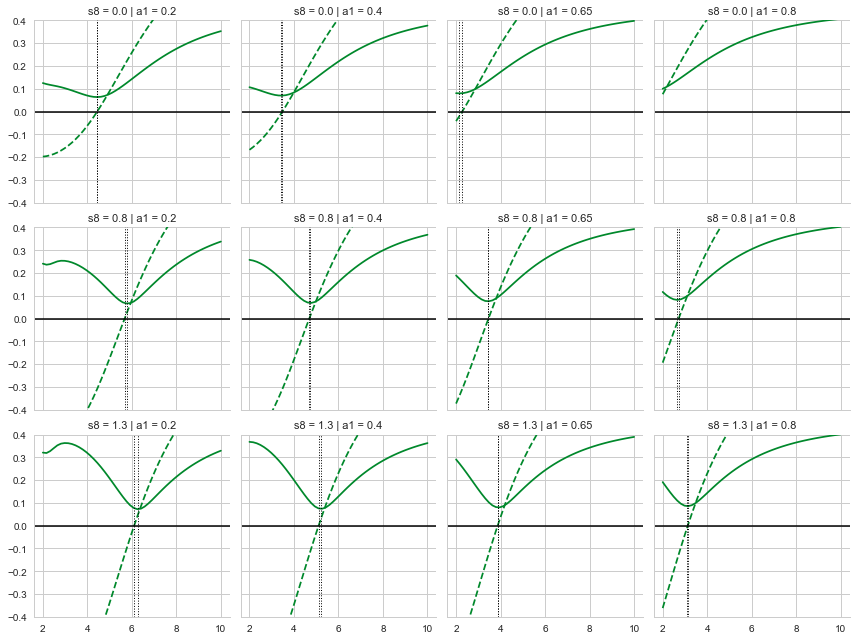

In [37]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)


g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

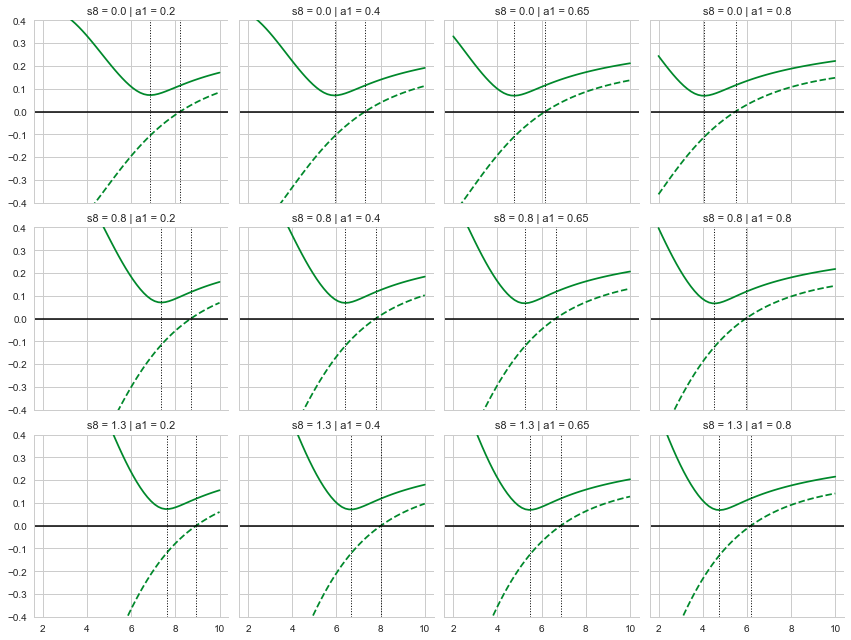

In [38]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

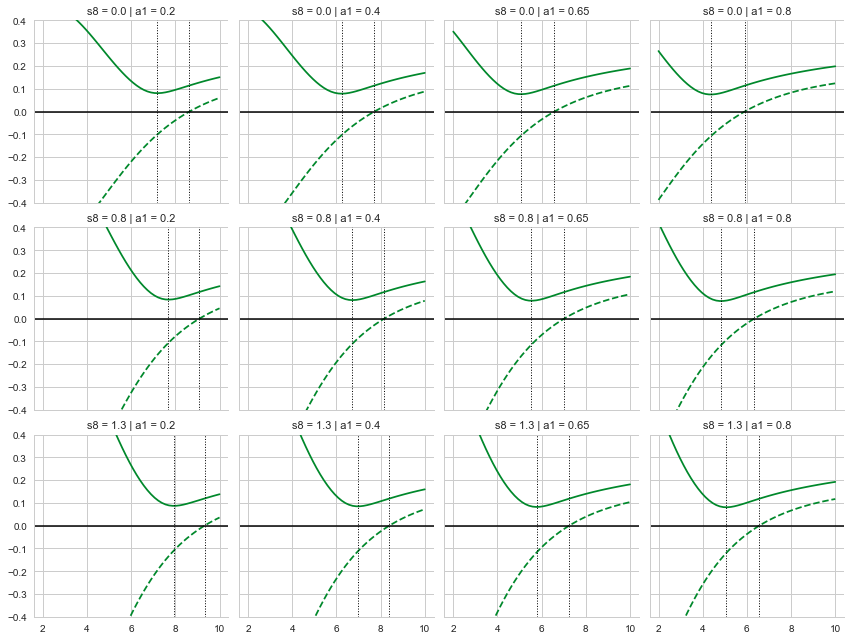

In [39]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

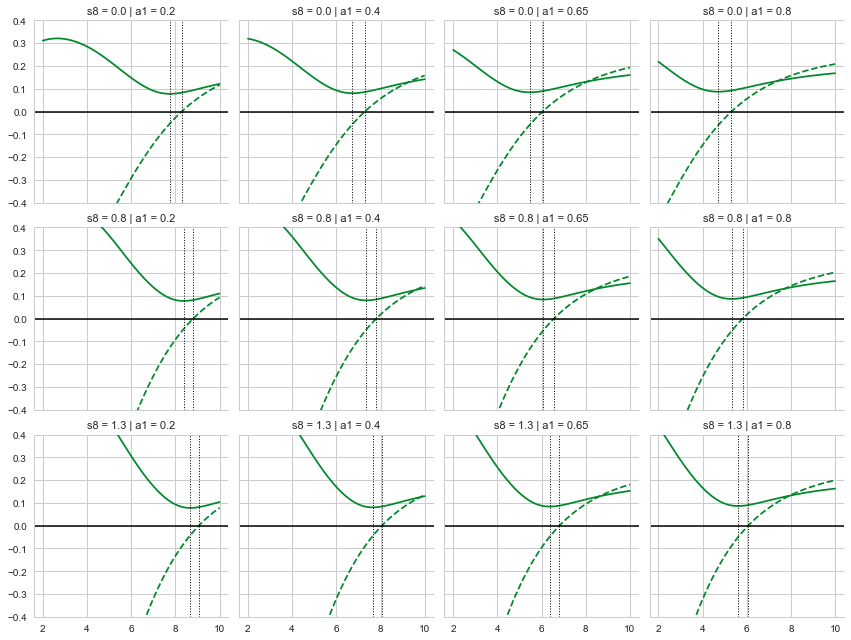

In [40]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

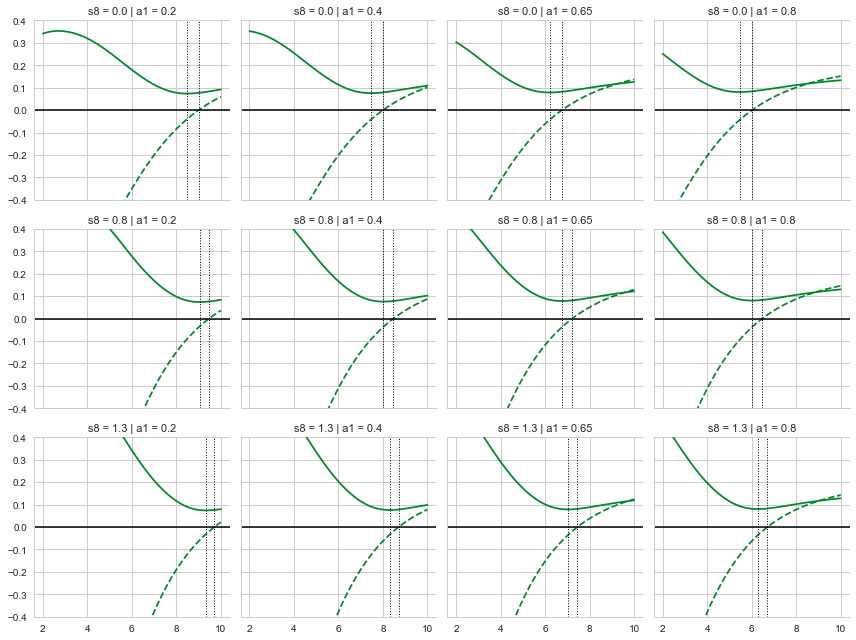

In [41]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

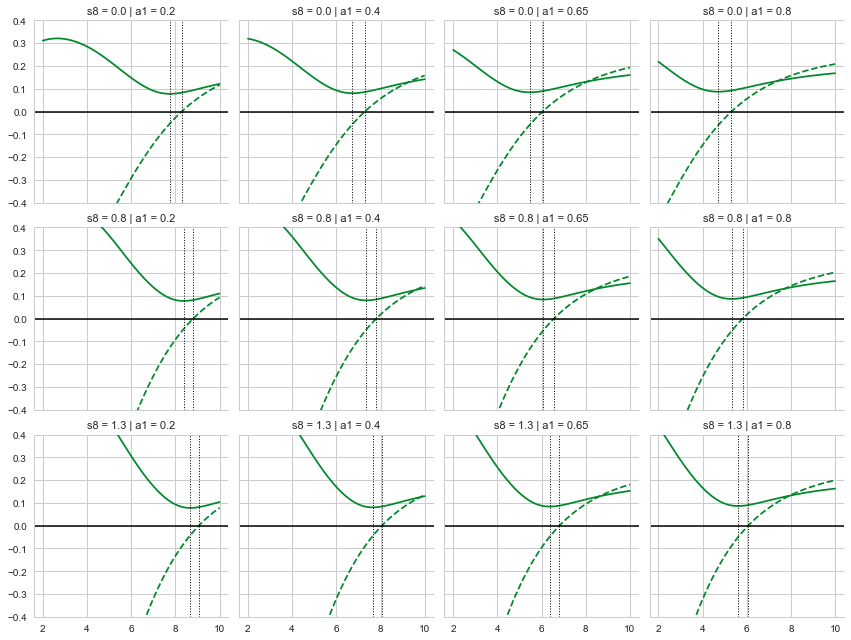

In [42]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

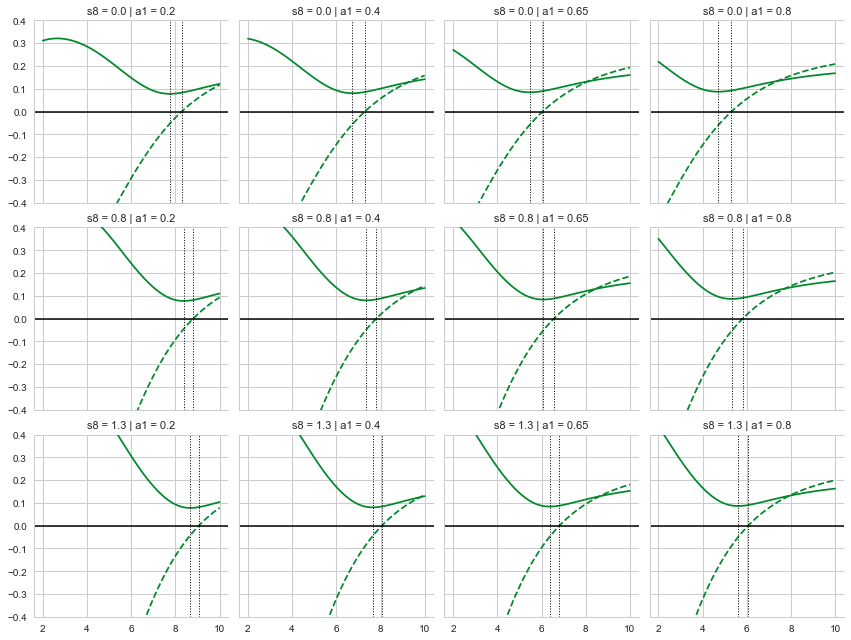

In [43]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

## D3 (zero)

In [44]:
data_scf.index.names, data_dftd3_0.index.names

(FrozenList(['name', 'system', 'dist', 'xc']),
 FrozenList(['name', 'system', 'dist', 'sr6', 'sr8', 's8']))

0.0949648547617 1.51863919543
0.094728951614 1.35854542652
0.0883453998419 1.08111806417


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


0.0946536372055 0.716485026763
0.104954603028 0.56090852583
0.0937142695305 1.86399843922
0.101678042318 1.70386036424
0.0963170023094 1.42644153529
0.0891822846783 1.06180909324
0.0902844792303 0.839542656657


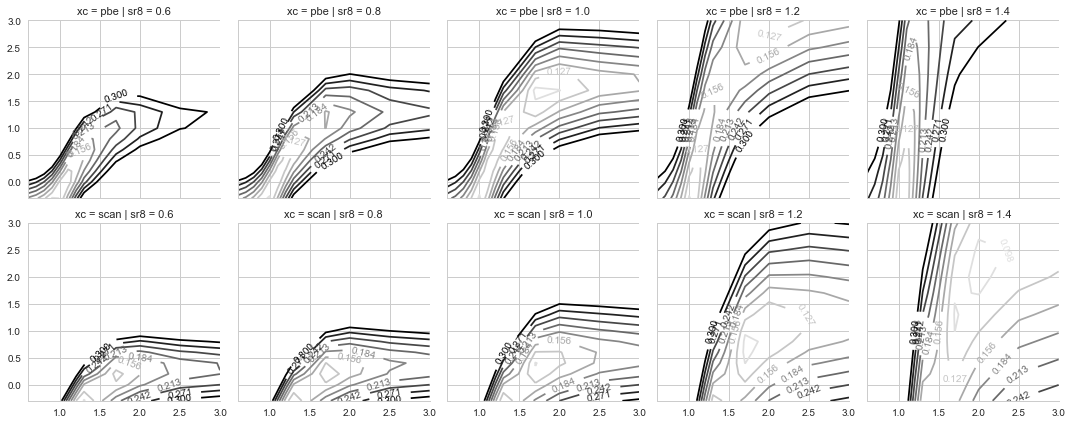

In [45]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('sr6 s8'.split()).apply(get_stat)
    df = df.MARE.reset_index().pivot(columns='sr6', index='s8', values='MARE')
    mare = df.as_matrix()
    print(mare.min(), mare.max())
    p = sns.plt.contour(df.columns, df.index, mare, np.linspace(0.04, 0.3, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_0, (slice(None, 9.), slice(None), slice(None)),
        'sr6 sr8 s8'.split()
    ).reset_index(),
    col='sr8',
    row='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()


In [46]:
def get_rows(df):
    sr = df.groupby(level='sr6 s8'.split()).apply(get_stat).MARE
    sr6_0, s8_0 = sr.idxmin()
    df = sr.reset_index().pivot(columns='sr6', index='s8', values='MARE')
    mare = df.as_matrix()
    f = interp2d(df.columns, df.index, mare, kind='cubic')
    bounds = [
        (df.columns.min()+1e-6, df.columns.max()-1e-6),
        (df.index.min()+1e-6, df.index.max()-1e-6),
    ]
    sr6_opt, s8_opt = minimize(
        lambda x: f(x[0], x[1]),
        (sr6_0, s8_0),
        bounds=bounds
    ).x
    return pd.Series({
        'MARE': f(sr6_opt, s8_opt)[0],
        's8': s8_opt,
        'sr6': sr6_opt,
        's80': s8_0,
        'sr60': sr6_0,
    })
    
merge_scf_vdw(
    ('S66x8', slice(None), slice(None)),
    data_scf, (['pbe', 'scan'],),
    data_dftd3_0, (slice(None, 9.), slice(None), slice(None)),
    'sr6 sr8 s8'.split()
).groupby(level='xc sr8'.split()).apply(get_rows)

MARE        s8  s80       sr6  sr60
xc   sr8                                         
pbe  0.6  0.088244 -0.299999 -0.3  0.947876   0.9
     0.8  0.089543 -0.245913 -0.3  0.986277   1.0
     1.0  0.082719  1.647933  1.7  1.767612   1.7
     1.2  0.091896 -0.299999 -0.3  1.022573   1.0
     1.4  0.096105 -0.299999 -0.3  1.044263   1.0
scan 0.6  0.082202 -0.173889 -0.3  1.398403   1.3
     0.8  0.087363 -0.159828 -0.3  1.406728   1.3
     1.0  0.094033  0.350699  0.4  1.724414   1.7
     1.2  0.086645  0.773838  0.6  1.773614   1.7
     1.4  0.088880  2.360198  2.0  2.095667   2.0

0.0924534554046 0.661857528639
0.0937142695305 0.609324986715
0.107732048437 0.539377544346
0.131408793719 0.629665063554
0.104675409318 0.525024250648
0.101644197844 0.711624797899
0.112158881683 0.510680864313
0.0963170023094 0.793623159651
0.110622693897 0.533406939321


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


0.0891822846783 0.875727835232
0.109811847133 0.614743311916
0.0908850776473 0.957840067268
0.109051444636 0.696240379598
0.0973884841794 1.04001285178
0.110657240124 0.818865920533
0.0952213572857 1.16341945223
0.0883453998419 0.982985883988
0.0967624384515 1.32804990684
0.117569804784 1.10634737221
0.0902844792303 1.45152186061
0.139215073658 1.31236875933
0.0922413433015 1.65771038978
0.110672648989 1.51863919543
0.0981279805993 1.86399843922


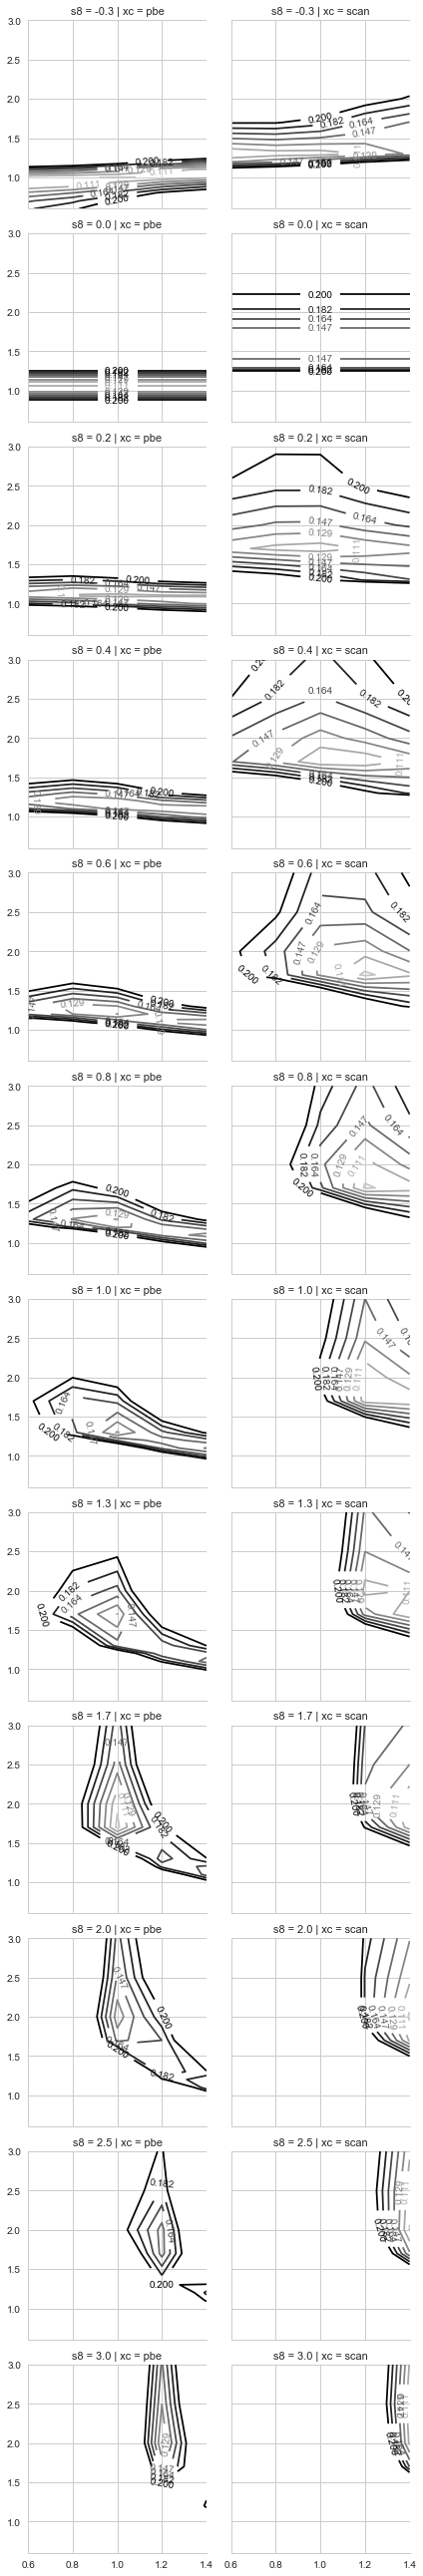

In [47]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('sr6 sr8'.split()).apply(get_stat)
    df = df.MARE.reset_index().pivot(index='sr6', columns='sr8', values='MARE')
    mare = df.as_matrix()
    print(mare.min(), mare.max())
    p = sns.plt.contour(df.columns, df.index, mare, np.linspace(0.04, 0.2, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_0, (slice(None, 9.), slice(None), slice(None)),
        'sr6 sr8 s8'.split()
    ).reset_index(),
    col='xc',
    row='s8'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()


# VV10

In [48]:
data_vv10_raw.index.names

FrozenList(['name', 'system', 'dist', 'b', 'xc', 'fragment'])

In [49]:
data_vv10_raw.reset_index()['fragment'].unique()

array(['complex', 'guest', 'host', 'fragment-1', 'fragment-2', 'crystal',
       'molecule'], dtype=object)

In [50]:
def interpolated_vv10():
    def func(r):
        return interp1d(r.index, r)
    return data_vv10['ene'].unstack().apply(func, axis=1)

interpolated_vv10()

name  system    dist  b   
S12L  2a        1.0   4.5     <scipy.interpolate.interpolate.interp1d object...
                      6.3     <scipy.interpolate.interpolate.interp1d object...
                      8.0     <scipy.interpolate.interpolate.interp1d object...
                      10.0    <scipy.interpolate.interpolate.interp1d object...
                      13.0    <scipy.interpolate.interpolate.interp1d object...
                      16.0    <scipy.interpolate.interpolate.interp1d object...
                      19.0    <scipy.interpolate.interpolate.interp1d object...
                      22.0    <scipy.interpolate.interpolate.interp1d object...
      2b        1.0   4.5     <scipy.interpolate.interpolate.interp1d object...
                      6.3     <scipy.interpolate.interpolate.interp1d object...
                      8.0     <scipy.interpolate.interpolate.interp1d object...
                      10.0    <scipy.interpolate.interpolate.interp1d object...
             

In [51]:
def interp_vv10(bs):
    def func(r):
        f = interp1d(r.index, r)
        return pd.Series({b: ene for b, ene in zip(bs, f(bs))})
    return data_vv10['ene'] \
        .unstack().apply(lambda r: r['nlc'] if r.name[0] == 'S12L' else r['vdw']-r['base'], axis=1) \
        .unstack().apply(func, axis=1).rename_axis('b', axis=1).stack().to_frame('ene')

interp_vv10([7.5123, 11])

ene
name system                               dist b                 
S12L 2a                                   1.0  7.5123  -26.852412
                                               11.0000 -16.719648
     2b                                   1.0  7.5123  -19.358967
                                               11.0000 -12.043127
     3a                                   1.0  7.5123  -25.306332
                                               11.0000 -16.181271
     3b                                   1.0  7.5123  -14.184980
                                               11.0000  -9.046634
     4a                                   1.0  7.5123  -43.056797
                                               11.0000 -27.836653
     4b                                   1.0  7.5123  -45.784914
                                               11.0000 -29.691366
     5a                                   1.0  7.5123  -18.738099
                                               11.0000 -11.726664
     5b                                   1.0  7.5123  -17.100949
                                               11.0000 -10.761426
     6a                                   1.0  7.5123  -20.903825
                                               11.0000 -13.367648
     6b                                   1.0  7.5123  -17.303790
                                               11.0000 -11.057515
     7a                                   1.0  7.5123  -46.662232
                                               11.0000 -30.498513
     7b                                   1.0  7.5123  -31.343742
                                               11.0000 -20.571231
S22  2-pyridoxine 2-aminopyridine complex 1.0  7.5123   -2.616403
                                               11.0000  -1.617063
     Adenine thymine Watson-Crick complex 1.0  7.5123   -2.840531
                                               11.0000  -1.755704
     Adenine thymine complex stack        1.0  7.5123   -8.248605
                                               11.0000  -5.008175
...                                                           ...
X23  ethcar                               1.0  7.5123  -12.120078
                                               11.0000  -8.092691
     formamide                            1.0  7.5123   -7.345031
                                               11.0000  -4.792043
     hexamine                             1.0  7.5123  -19.894722
                                               11.0000 -13.683248
     hexdio                               1.0  7.5123  -16.676220
                                               11.0000 -11.210363
     imdazole                             1.0  7.5123  -10.887175
                                               11.0000  -7.230773
     naph                                 1.0  7.5123  -19.799125
                                               11.0000 -13.298702
     oxaca                                1.0  7.5123  -12.904531
                                               11.0000  -8.570046
     oxacb                                1.0  7.5123  -12.648653
                                               11.0000  -8.408736
     pyrazine                             1.0  7.5123  -12.712795
                                               11.0000  -8.458549
     pyrazole                             1.0  7.5123  -10.291362
                                               11.0000  -6.850698
     succinic                             1.0  7.5123  -17.239604
                                               11.0000 -11.503317
     triazine                             1.0  7.5123  -12.067689
                                               11.0000  -8.063104
     trioxane                             1.0  7.5123  -12.465645
                                               11.0000  -8.427906
     uracil                               1.0  7.5123  -16.409633
                                               11.0000 -10.951307
     urea                           

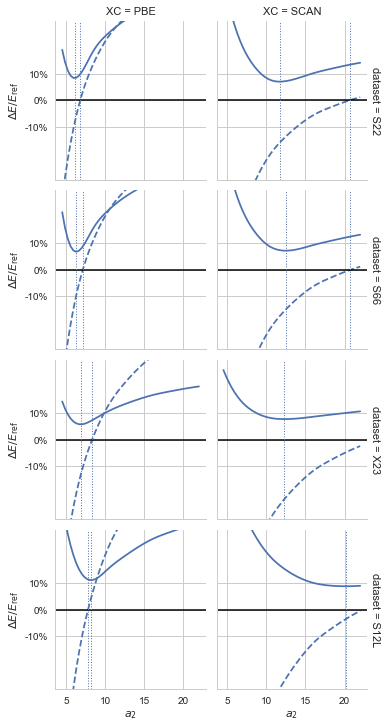

In [52]:
lines = {}

def plot_stat(**kwargs):
    param = 'b'
    df = kwargs.pop('data').groupby(param).apply(get_stat).reset_index()
    color = kwargs.pop('color')
    mean = interp1d(df[param], df['mean'], kind='cubic')
    std = interp1d(df[param], df['STD'], kind='cubic')
    a2 = np.linspace(df[param].min(), df[param].max())
    lines['-', color], = sns.plt.plot(a2, mean(a2), '--', color=color)
    lines['--', color], = sns.plt.plot(a2, std(a2), '-', color=color)
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df[param].min()+1e-6, df[param].max()-1e-6)]
    opt_std = minimize(std, 10., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color=color, ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color=color, ls='dotted', lw=1)
        
g = sns.FacetGrid(
    merge_scf_vdw_multi(
        (['S22', 'S66x8', 'X23', 'S12L'], slice(None), 1.),
        data_scf, [(['pbe', 'scan'],)],
        interp_vv10(np.linspace(4.5, 22., 10)), [()],
        'b'.split()
    ).reset_index()
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    row='dataset',
    col='XC',
    size=2.5,
    row_order='S22 S66 X23 S12L'.split(),
    margin_titles=True
).map_dataframe(plot_stat)

# lgnd = g.fig.legend(
#     lines,
#     ('mean', 'standard deviation', '$a_1=0.3$, $s_8=0.8$', '$a_2=0.55$, $s_8=0$'),
#     loc='center left', bbox_to_anchor=(1.15, .53), ncol=1
# )
# g.fig.subplots_adjust(bottom=0.3, left=0.25, right=.6)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$a_2$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [2, 10]
yticks = [-.1, 0, .1]
g.set(yticks=yticks)
g.set_yticklabels(['-10%', '0%', '10%'])
# savefig(bbox_inches='tight')